In [97]:
import argparse
import copy
import itertools
import warnings
import os

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from lightgbm import LGBMClassifier
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import (
    SelectFromModel,
    SelectKBest,
    VarianceThreshold,
    f_classif,
)
from sklearn.metrics import (
    auc,
    matthews_corrcoef,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, label_binarize, StandardScaler
from sklearn.svm import SVC
from huggingface_hub import login
from tabpfn import TabPFNClassifier
# from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier

from xgboost import XGBClassifier
from itertools import combinations


# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)



# OvO and OvR prediction function

In [98]:
def split_classes(X, y):
    return {
        (c1, c2): (X[(y == c1) | (y == c2)], y[(y == c1) | (y == c2)])
        for c1, c2 in itertools.combinations(np.unique(y), 2)
    }


def ovo_and_ova_multiclass_auc(X, y, base_clf, p_grid, random_state):
    results = {}
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    class_names = le.classes_

    # Stratified K-Folds
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    ####################
    # One-vs-Rest Classification
    ####################
    print("Performing One vs Rest classification")

    #checking grid search enabled or not 
    if p_grid is not None:
        ovr_clf = GridSearchCV(
            estimator=OneVsRestClassifier(base_clf),
            param_grid=p_grid,
            cv=inner_cv,
            scoring="roc_auc_ovr",
        )
    else:
        ovr_clf = OneVsRestClassifier(base_clf)
   
    
    y_score = cross_val_predict(ovr_clf, X, y_encoded, cv=outer_cv, method="predict_proba") 
    y_pred = np.argmax(y_score, axis=1) 
    
    # Per-class metrics for OvR 
    per_class_precision = [] 
    per_class_recall = [] 
    per_class_f1 = [] 
    per_class_mcc = []

    for idx, cls in enumerate(class_names): 
        y_bin = (y_encoded == idx).astype(int) 
        cls_score = y_score[:, idx] 
        
        # Ensure minority class is positive 
        if np.sum(y_bin) > np.sum(1 - y_bin): 
            y_bin = 1 - y_bin 
            cls_score = 1 - cls_score 
            
        y_pred_bin = (y_pred == idx).astype(int) 
        precision, recall, f1, _ = precision_recall_fscore_support(y_bin, y_pred_bin, average="binary") 
        mcc = matthews_corrcoef(y_bin, y_pred_bin) 
        prec_curve, rec_curve, _ = precision_recall_curve(y_bin, cls_score) 
        pr_auc_val = auc(rec_curve, prec_curve) 
        roc_auc_val = roc_auc_score(y_bin, cls_score) 
        
        results[f"{cls} vs Rest - Precision"] = precision 
        results[f"{cls} vs Rest - Recall"] = recall 
        results[f"{cls} vs Rest - F1"] = f1 
        results[f"{cls} vs Rest - MCC"] = mcc 
        results[f"{cls} vs Rest - PR AUC"] = pr_auc_val 
        results[f"{cls} vs Rest - ROC AUC"] = roc_auc_val 
        
        per_class_precision.append(precision) 
        per_class_recall.append(recall) 
        per_class_f1.append(f1) 
        per_class_mcc.append(mcc) 
    
    # Macro metrics OvR 

    macro_ovr_auc = np.mean([results[f"{cls} vs Rest - ROC AUC"] for cls in class_names]) 
    macro_ovr_precision = np.mean(per_class_precision) 
    macro_ovr_recall = np.mean(per_class_recall) 
    macro_ovr_f1 = np.mean(per_class_f1) 
    macro_ovr_mcc = np.mean(per_class_mcc)
    macro_ovr_pr_auc = np.mean([results[f"{cls} vs Rest - PR AUC"] for cls in class_names])

    
    results["OvR Macro ROC AUC"] = macro_ovr_auc
    results["OvR Macro Precision"] = macro_ovr_precision
    results["OvR Macro Recall"] = macro_ovr_recall
    results["OvR Macro F1"] = macro_ovr_f1 
    results["OvR Macro MCC"] =  macro_ovr_mcc
    results["OvR Macro PR AUC"] = macro_ovr_pr_auc 

    print(f"Macro ROC AUC (OvR): {macro_ovr_auc:.4f}")
    print(f"Macro Precision (OvR): {macro_ovr_precision:.4f}")
    print(f"Macro Recall (OvR): {macro_ovr_recall:.4f}")
    print(f"Macro F1 (OvR): {macro_ovr_f1:.4f}")
    print(f"Macro MCC (OvR): {macro_ovr_mcc:.4f}")
    print(f"Macro PR AUC (OvR): {macro_ovr_pr_auc:.4f}")

    

    #avoiding  meaningless computation as OvO metrics won’t make sense with TabPFN
    if isinstance(base_clf, Pipeline) and isinstance(base_clf.named_steps["classification"], TabPFNClassifier):
        print("Skipping One-vs-One metrics for TabPFN")
    else:
        
        ####################
        # One-vs-One Classification
        ####################
        print("Performing One vs One classification")
    
        ovo_auc = {} 
        ovo_precision = {} 
        ovo_recall = {} 
        ovo_f1 = {} 
        ovo_mcc = {} 
        
        for c1, c2 in combinations(range(len(class_names)), 2): 
            mask = np.isin(y_encoded, [c1, c2]) 
            X_pair, y_pair = X[mask], y_encoded[mask] 
    
            # checking grid search enabled or not
            if p_grid is not None:
                ovo_clf = GridSearchCV(
                    estimator=base_clf,
                    param_grid={k.replace("estimator__", ""): v for k, v in p_grid.items()},
                    cv=inner_cv,
                    scoring="roc_auc"
                )
            else:
                ovo_clf = base_clf
                
            y_score_pair = cross_val_predict(ovo_clf, X_pair, y_pair, cv=outer_cv, method="predict_proba") 
            
            # Identify minority 
            
            vals, counts = np.unique(y_pair, return_counts=True) 
            minority = vals[np.argmin(counts)] 
            minority_idx = np.where([c1, c2] == minority)[0][0] 
            
            y_bin = (y_pair == minority).astype(int) 
            y_score_cls = y_score_pair[:, minority_idx] 
            
            # Ensure minority positive 
            
            if np.sum(y_bin) > np.sum(1 - y_bin): 
                y_bin = 1 - y_bin 
                y_score_cls = 1 - y_score_cls 
                
            y_pred_bin = (np.argmax(y_score_pair, axis=1) == minority_idx).astype(int)
                                                                                 
            precision, recall, f1, _ = precision_recall_fscore_support(y_bin, y_pred_bin, average="binary") 
            mcc = matthews_corrcoef(y_bin, y_pred_bin) 
            prec_curve, rec_curve, _ = precision_recall_curve(y_bin, y_score_cls) 
            pr_auc_val = auc(rec_curve, prec_curve) 
            roc_auc_val = roc_auc_score(y_bin, y_score_cls)
            
            pair_name = f"{le.inverse_transform([c1])[0]} vs {le.inverse_transform([c2])[0]}" 
            
            results[f"{pair_name} - Precision"] = precision 
            results[f"{pair_name} - Recall"] = recall 
            results[f"{pair_name} - F1"] = f1 
            results[f"{pair_name} - MCC"] = mcc 
            results[f"{pair_name} - PR AUC"] = pr_auc_val 
            results[f"{pair_name} - ROC AUC"] = roc_auc_val 
            
            ovo_auc[(c1, c2)] = roc_auc_val 
            ovo_precision[(c1, c2)] = precision 
            ovo_recall[(c1, c2)] = recall 
            ovo_f1[(c1, c2)] = f1 
            ovo_mcc[(c1, c2)] = mcc 
            
            
        # Macro metrics OvO 
        macro_ovo_auc = np.mean(list(ovo_auc.values()))
        macro_ovo_precision = np.mean(list(ovo_precision.values()))
        macro_ovo_recall = np.mean(list(ovo_recall.values())) 
        macro_ovo_f1 = np.mean(list(ovo_f1.values())) 
        macro_ovo_mcc = np.mean(list(ovo_mcc.values())) 
        macro_ovo_pr_auc = np.mean([results[k] for k in results if "vs" in k and "PR AUC" in k]) 
    
        results["OvO Macro ROC AUC"] =  macro_ovo_auc
        results["OvO Macro Precision"] = macro_ovo_precision
        results["OvO Macro Recall"] = macro_ovo_recall
        results["OvO Macro F1"] = macro_ovo_f1
        results["OvO Macro MCC"] = macro_ovo_mcc
        results["OvO Macro PR AUC"] =  macro_ovo_pr_auc
    
    
        print(f"Macro ROC AUC (OvO): {macro_ovo_auc:.4f}")
        print(f"Macro Precision (OvO): {macro_ovo_precision:.4f}")
        print(f"Macro Recall (OvO): {macro_ovo_recall:.4f}")
        print(f"Macro F1 (OvO): {macro_ovo_f1:.4f}")
        print(f"Macro MCC (OvO): {macro_ovo_mcc:.4f}")
        print(f"Macro PR AUC (OvO): {macro_ovo_pr_auc:.4f}")
    
    return results


def repeat_clf(n_seeds, ks, X, y, label, model, sampling_strategy, use_grid=False):

    print("features(ks): ", ks)
    print("seeds: ", n_seeds)

    # Define sampling strategies
    sampling_strategies = {
        "No Sampling": None,
        "Random OverSampling": RandomOverSampler(random_state=42),
        "SMOTE": SMOTE(random_state=42),
        "Random UnderSampling": RandomUnderSampler(random_state=42),
        "NearMiss (v1)": NearMiss(version=1),
        "NearMiss (v2)": NearMiss(version=2),
        "NearMiss (v3)": NearMiss(version=3),
    }

    # If the selected strategy is not in the dictionary, use "No Sampling"
    sampler = sampling_strategies.get(sampling_strategy, None)

    seed_results = {}

    for seed in range(n_seeds):

        ks_results = {}
        for k in ks:

            print(f"CV for seed {seed} and {k} features")

            # Create a Random Forest Classifier
            rf = RandomForestClassifier(random_state=seed)

            # Create a SelectFromModel using the Random Forest Classifier
            selector = SelectFromModel(rf, max_features=k)

            if model == "rf":
                ml_model = rf
                ml_model_grid = {
                    "estimator__classification__n_estimators":[100, 300, 500],  # Number of trees in the forest
                    "estimator__classification__max_depth": [None, 10, 20, 30],  # tree depth
                    "estimator__classification__max_features": ["sqrt", "log2"],  # Feature selection strategy
                    "estimator__classification__criterion": ["entropy"],  # Split criterion
                    "estimator__classification__min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf
                }
            elif model == "xgb":
                ml_model = XGBClassifier(
                    use_label_encoder=False, eval_metric="logloss", random_state=seed
                )
                ml_model_grid = {
                    "estimator__classification__n_estimators": [100, 300, 500], 
                    "estimator__classification__gamma": [0, 0.1, 0.3], # min loss reduction
                    "estimator__classification__max_depth": [3, 5, 7], 
                    "estimator__classification__learning_rate": [0.01, 0.05, 0.1], # step size
                }
            elif model == "etc":
                ml_model = ExtraTreesClassifier(random_state=seed)
                ml_model_grid = {
                    "estimator__classification__n_estimators": [100, 300, 500],
                    "estimator__classification__max_depth": [None, 10, 20],       # tree depth
                    "estimator__classification__max_features": ["sqrt", "log2"],  # features per split
                    "estimator__classification__min_samples_leaf": [1, 2, 4],     # min leaf samples
                    
                }
            elif model == "lgbm":
                ml_model = LGBMClassifier(random_state=seed, verbose=-1)
                ml_model_grid = {
                    "estimator__classification__n_estimators": [100, 300, 500],  
                    "estimator__classification__learning_rate": [0.01, 0.05, 0.1],
                    "estimator__classification__num_leaves": [31, 63, 127],      # leaves per tree
                            
                }
            elif model == "tabpfn":
    
                ml_model = TabPFNClassifier(
                    device="cpu",  
                    n_estimators=32  # default
                )
                ml_model_grid = None  # TabPFN does not use GridSearch

            # If there is a sampler, include it in the pipeline
            steps = []
            if sampler:
                steps.append(("sampling", sampler))
            steps.append(("feature_selection", selector))
            steps.append(("classification", ml_model))

            # Create a pipeline with feature selection, sampling, and classification
            pipeline = Pipeline(steps=steps)

            ###########################

            # Run the classification with the sampling strategy
            if use_grid:
                results = ovo_and_ova_multiclass_auc(
                    X, y, pipeline, ml_model_grid, random_state=seed
                )
            else:
                results = ovo_and_ova_multiclass_auc(
                    X, y, pipeline, None, random_state=seed
                )
                       

            print(results)

            ks_results[k] = {
                "results": results,
                "Label": label,
                "Model": model,
                "Sampling_Strategy": sampling_strategy,
            }


        seed_results[seed] = copy.copy(ks_results)

    return seed_results


def store_results(seed_results, output):

    # Flatten the nested dictionary into a DataFrame
    '''df = pd.DataFrame(
        {
            (outer_key, inner_key): values
            for outer_key, inner_dict in seed_results.items()
            for inner_key, values in inner_dict.items()
        }
    ).T

    # '''
    
    final_results = []
    metrics = ["ROC AUC", "Precision", "Recall", "F1", "MCC", "PR AUC"]
    
    for seed, ks_results in seed_results.items():
        for k, result_info in ks_results.items():
            result = result_info["results"]
            model = result_info["Model"]
            sampling_strategy = result_info["Sampling_Strategy"]
            label=result_info["Label"]
                        
            # Determine Class and Type
           
            groups = set()
            for key in result.keys():
                if "Macro" in key:
                    groups.add(("Macro", "OvR" if "OvR" in key else "OvO"))
                elif "vs Rest" in key:
                    groups.add((key.split(" vs Rest")[0], "OvR"))
                else:
                    groups.add((key.split(" - ")[0], "OvO"))

            # assign metric values according to class and type
            for class_name, type_name in groups:

                metric_values = {}
            
                for metric in metrics:
                    metric_key = None
            
                    for key in result.keys():
                        if class_name == "Macro":
                            if metric in key and "Macro" in key and type_name in key:
                                metric_key = key
                                break
                        elif type_name == "OvR":
                            if metric in key and f"{class_name} vs Rest" in key:
                                metric_key = key
                                break
                        else:  # OvO
                            if metric in key and "vs" in key and class_name in key:
                                metric_key = key
                                break
            
                    metric_values[metric] = result[metric_key] if metric_key else np.nan

                final_results.append({
                    "Seed": seed,
                    "Features (k)": k,
                    "Label": label,
                    "Model": model,
                    "Sampling_Strategy": sampling_strategy,
                    "Class": class_name,
                    "Type": type_name,
                    **metric_values
                })
                
    df = pd.DataFrame(final_results)

    '''#Set multi-level index names for clarity
    df.set_index(["Seed", "Features (k)", "Label", "Model", "Sampling_Strategy"], inplace=True)

    df.index.names = ["Seed", "Features (k)","Label","Model","Sampling_Strategy"]
    # Display the DataFrame
    df = df.reset_index()'''

    df.to_csv(output, mode='a', header=not os.path.exists(output), index=False)

    print(df)


def run_classification(X, y, ks, n_seeds,output, label,model, sampling_strategy,use_grid=False):

    '''# Ensure ks does not exceed the number of columns in X
    max_features = len(X.columns)
    ks = [k for k in ks if k <= max_features]
    if max_features not in ks:
        ks.append(max_features)'''

    seed_results = repeat_clf(n_seeds, ks, X, y, label,model, sampling_strategy, use_grid=use_grid)
    store_results(seed_results, output)



# Import omics and metadata data

In [99]:
# Step 1: Define folder
output_dir = "HP_analysis_10_2025/input/HP_multiomics/"

# Step 2: Initialize list to store omics datasets
raw_data = []

# Step 3: Loop through all TSV files (excluding metadata and Virulence-Genes)
for file in os.listdir(output_dir):
    if (
        file.endswith("_clean.tsv") 
        and file != "metadata_clean.tsv"
        and not file.startswith("Virulence-Genes")
    ):
        name = file.replace("_clean.tsv", "")
        df = pd.read_csv(os.path.join(output_dir, file), sep="\t", index_col=0)
        raw_data.append({"name": name, "df": df})

# Step 4: Load metadata separately
metadata_path = os.path.join(output_dir, "metadata_clean.tsv")
y_aligned = pd.read_csv(metadata_path, sep="\t", index_col=0)

# Step 5: Print summary
print(f"Loaded {len(raw_data)} omics datasets:")
for omic in raw_data:
    print(f" - {omic['name']}: {omic['df'].shape[0]} samples × {omic['df'].shape[1]} features")

print(f"Metadata loaded with shape: {y_aligned.shape}")
print("\nDataset loading complete. (Virulence-Genes excluded)")

Loaded 6 omics datasets:
 - SCFA: 134 samples × 27 features
 - Metabolites: 134 samples × 439 features
 - GCMS: 134 samples × 99 features
 - Lipids: 134 samples × 622 features
 - 16S: 134 samples × 6241 features
 - RNA: 134 samples × 60839 features
Metadata loaded with shape: (134, 31)

Dataset loading complete. (Virulence-Genes excluded)


# Apply TSS and merge data

In [100]:
# --- Total Sum Scaling function ---
def total_sum_scale(df):
    df = df.fillna(0)
    return df.div(df.sum(axis=1), axis=0)

# --- Prepare TSS datasets ---
tss_datasets = []
dataset_names = []

for omics_data in raw_data:
    df_tss = total_sum_scale(omics_data["df"])
    tss_datasets.append(df_tss)
    dataset_names.append(omics_data["name"])

# --- Combined dataset ---
df_combined = pd.concat(tss_datasets, axis=1)
tss_datasets.append(df_combined)
dataset_names.append("Combined")

# --- Encode target ---
y_target = y_aligned["Sample_Condition"]

#print(df_combined)


# Test combined dataset - on all 4 models (no grid search) , 10, 100 and all features

In [8]:
n_seeds = 2
ks = [10,100,len(df_combined.columns)]  # all features 
result_path="HP_analysis_10_2025/benchmark/results/diff_models_on_combined(no grid).csv"
# Check if the file exists and remove it once
if os.path.exists(result_path):
    print(f"File {result_path} exists. Deleting it to start fresh.")
    os.remove(result_path)
    
for model in ['rf', 'xgb', 'etc', 'lgbm']:
    print(f"model: {model} ")
    print("Combined dataset scores:")
    run_classification(df_combined, y_target, ks, n_seeds,result_path,"combined", model, None,use_grid=False)

    

File HP_analysis_10_2025/benchmark/results/diff_models_on_combined(no grid).csv exists. Deleting it to start fresh.
model: rf 
Combined dataset scores:
[10, 100, 68267]
2
CV for seed 0 and 10 features
Performing One vs Rest classification
Macro ROC AUC (OvR): 0.6698
Macro Precision (OvR): 0.4195
Macro Recall (OvR): 0.3926
Macro F1 (OvR): 0.3289
Macro MCC (OvR): 0.0719
Macro PR AUC (OvR): 0.4313
Performing One vs One classification
Macro ROC AUC (OvO): 0.6592
Macro Precision (OvO): 0.4858
Macro Recall (OvO): 0.2667
Macro F1 (OvO): 0.3416
Macro MCC (OvO): 0.2072
Macro PR AUC (OvO): 0.4500
{'Negative control vs Rest - Precision': 0.29411764705882354, 'Negative control vs Rest - Recall': 0.7777777777777778, 'Negative control vs Rest - F1': 0.4268292682926829, 'Negative control vs Rest - MCC': np.float64(-0.2487145971214342), 'Negative control vs Rest - PR AUC': np.float64(0.5004385697013709), 'Negative control vs Rest - ROC AUC': np.float64(0.5749063670411986), 'Patient vs Rest - Precision

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.7391
Macro Precision (OvO): 0.4444
Macro Recall (OvO): 0.1333
Macro F1 (OvO): 0.1979
Macro MCC (OvO): 0.1859
Macro PR AUC (OvO): 0.5265
{'Negative control vs Rest - Precision': 0.3153846153846154, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.4685714285714286, 'Negative control vs Rest - MCC': np.float64(-0.24668745581139884), 'Negative control vs Rest - PR AUC': np.float64(0.6658272755275458), 'Negative control vs Rest - ROC AUC': np.float64(0.7204744069912609), 'Patient vs Rest - Precision': 0.5, 'Patient vs Rest - Recall': 0.06666666666666667, 'Patient vs Rest - F1': 0.11764705882352941, 'Patient vs Rest - MCC': np.float64(0.15149987190590394), 'Patient vs Rest - PR AUC': np.float64(0.6076966297607611), 'Patient vs Rest - ROC AUC': np.float64(0.7983193277310925), 'Positive control vs Rest - Precision': 0.5, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.0625, 'Positive 

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:50:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:50:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:50:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:50:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro ROC AUC (OvR): 0.6563
Macro Precision (OvR): 0.3417
Macro Recall (OvR): 0.3556
Macro F1 (OvR): 0.2611
Macro MCC (OvR): 0.0442
Macro PR AUC (OvR): 0.4024
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:51:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:51:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:51:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:51:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro ROC AUC (OvO): 0.6333
Macro Precision (OvO): 0.3849
Macro Recall (OvO): 0.3333
Macro F1 (OvO): 0.3554
Macro MCC (OvO): 0.1693
Macro PR AUC (OvO): 0.4122
{'Negative control vs Rest - Precision': 0.325, 'Negative control vs Rest - Recall': 0.8666666666666667, 'Negative control vs Rest - F1': 0.4727272727272727, 'Negative control vs Rest - MCC': np.float64(-0.06708004529858762), 'Negative control vs Rest - PR AUC': np.float64(0.4634786717363215), 'Negative control vs Rest - ROC AUC': np.float64(0.5667915106117353), 'Patient vs Rest - Precision': 0.5, 'Patient vs Rest - Recall': 0.13333333333333333, 'Patient vs Rest - F1': 0.21052631578947367, 'Patient vs Rest - MCC': np.float64(0.2158949843273416), 'Patient vs Rest - PR AUC': np.float64(0.49102292849692414), 'Patient vs Rest - ROC AUC': np.float64(0.8616246498599439), 'Positive control vs Rest - Precision': 0.2, 'Positive control vs Rest - Recall': 0.06666666666666667, 'Positive control vs Rest - F1': 0.1, 'Positive control vs Rest 

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:51:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:51:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:51:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:51:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro ROC AUC (OvR): 0.6875
Macro Precision (OvR): 0.4520
Macro Recall (OvR): 0.3778
Macro F1 (OvR): 0.3310
Macro MCC (OvR): 0.0773
Macro PR AUC (OvR): 0.4742
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:51:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:51:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:51:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:51:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro ROC AUC (OvO): 0.7111
Macro Precision (OvO): 0.5811
Macro Recall (OvO): 0.3444
Macro F1 (OvO): 0.4315
Macro MCC (OvO): 0.3021
Macro PR AUC (OvO): 0.5255
{'Negative control vs Rest - Precision': 0.2894736842105263, 'Negative control vs Rest - Recall': 0.7333333333333333, 'Negative control vs Rest - F1': 0.41509433962264153, 'Negative control vs Rest - MCC': np.float64(-0.23429583803406906), 'Negative control vs Rest - PR AUC': np.float64(0.5584972492497657), 'Negative control vs Rest - ROC AUC': np.float64(0.6751560549313359), 'Patient vs Rest - Precision': 0.8, 'Patient vs Rest - Recall': 0.26666666666666666, 'Patient vs Rest - F1': 0.4, 'Patient vs Rest - MCC': np.float64(0.42963727941822466), 'Patient vs Rest - PR AUC': np.float64(0.5563400816619133), 'Patient vs Rest - ROC AUC': np.float64(0.8341736694677871), 'Positive control vs Rest - Precision': 0.26666666666666666, 'Positive control vs Rest - Recall': 0.13333333333333333, 'Positive control vs Rest - F1': 0.177777777777777

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:52:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:52:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:52:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:52:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro ROC AUC (OvR): 0.6753
Macro Precision (OvR): 0.5653
Macro Recall (OvR): 0.3852
Macro F1 (OvR): 0.3235
Macro MCC (OvR): 0.0877
Macro PR AUC (OvR): 0.4365
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:52:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:52:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:52:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:52:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro ROC AUC (OvO): 0.7041
Macro Precision (OvO): 0.5602
Macro Recall (OvO): 0.2444
Macro F1 (OvO): 0.3378
Macro MCC (OvO): 0.2511
Macro PR AUC (OvO): 0.4765
{'Negative control vs Rest - Precision': 0.296, 'Negative control vs Rest - Recall': 0.8222222222222222, 'Negative control vs Rest - F1': 0.43529411764705883, 'Negative control vs Rest - MCC': np.float64(-0.3142304826507743), 'Negative control vs Rest - PR AUC': np.float64(0.5352098958950471), 'Negative control vs Rest - ROC AUC': np.float64(0.6419475655430711), 'Patient vs Rest - Precision': 1.0, 'Patient vs Rest - Recall': 0.26666666666666666, 'Patient vs Rest - F1': 0.42105263157894735, 'Patient vs Rest - MCC': np.float64(0.49406736797987794), 'Patient vs Rest - PR AUC': np.float64(0.47837878733603484), 'Patient vs Rest - ROC AUC': np.float64(0.7983193277310925), 'Positive control vs Rest - Precision': 0.4, 'Positive control vs Rest - Recall': 0.06666666666666667, 'Positive control vs Rest - F1': 0.11428571428571428, 'Positive

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:52:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:52:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:52:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:52:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro ROC AUC (OvR): 0.6126
Macro Precision (OvR): 0.3182
Macro Recall (OvR): 0.4074
Macro F1 (OvR): 0.3181
Macro MCC (OvR): 0.0901
Macro PR AUC (OvR): 0.3572
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro ROC AUC (OvO): 0.6287
Macro Precision (OvO): 0.3569
Macro Recall (OvO): 0.2778
Macro F1 (OvO): 0.3059
Macro MCC (OvO): 0.1269
Macro PR AUC (OvO): 0.3661
{'Negative control vs Rest - Precision': 0.3333333333333333, 'Negative control vs Rest - Recall': 0.8222222222222222, 'Negative control vs Rest - F1': 0.47435897435897434, 'Negative control vs Rest - MCC': np.float64(-0.01157111091273432), 'Negative control vs Rest - PR AUC': np.float64(0.42987715993090647), 'Negative control vs Rest - ROC AUC': np.float64(0.5468164794007491), 'Patient vs Rest - Precision': 0.45454545454545453, 'Patient vs Rest - Recall': 0.3333333333333333, 'Patient vs Rest - F1': 0.38461538461538464, 'Patient vs Rest - MCC': np.float64(0.3249551091396129), 'Patient vs Rest - PR AUC': np.float64(0.4376955042921128), 'Patient vs Rest - ROC AUC': np.float64(0.8072829131652661), 'Positive control vs Rest - Precision': 0.16666666666666666, 'Positive control vs Rest - Recall': 0.06666666666666667, 'Positive control v

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro ROC AUC (OvR): 0.6186
Macro Precision (OvR): 0.4676
Macro Recall (OvR): 0.3593
Macro F1 (OvR): 0.2815
Macro MCC (OvR): 0.0740
Macro PR AUC (OvR): 0.3663
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro ROC AUC (OvO): 0.6614
Macro Precision (OvO): 0.4917
Macro Recall (OvO): 0.2111
Macro F1 (OvO): 0.2915
Macro MCC (OvO): 0.2080
Macro PR AUC (OvO): 0.4047
{'Negative control vs Rest - Precision': 0.31932773109243695, 'Negative control vs Rest - Recall': 0.8444444444444444, 'Negative control vs Rest - F1': 0.4634146341463415, 'Negative control vs Rest - MCC': np.float64(-0.09836381810967999), 'Negative control vs Rest - PR AUC': np.float64(0.44671916622672314), 'Negative control vs Rest - ROC AUC': np.float64(0.5935081148564295), 'Patient vs Rest - Precision': 1.0, 'Patient vs Rest - Recall': 0.2, 'Patient vs Rest - F1': 0.3333333333333333, 'Patient vs Rest - MCC': np.float64(0.4262386530020208), 'Patient vs Rest - PR AUC': np.float64(0.4526715549886218), 'Patient vs Rest - ROC AUC': np.float64(0.792717086834734), 'Positive control vs Rest - Precision': 0.08333333333333333, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.04761904761904761

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:54:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:54:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro ROC AUC (OvR): 0.6092
Macro Precision (OvR): 0.4000
Macro Recall (OvR): 0.3667
Macro F1 (OvR): 0.2569
Macro MCC (OvR): 0.0780
Macro PR AUC (OvR): 0.3274
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:54:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:54:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:54:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:54:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro ROC AUC (OvO): 0.6886
Macro Precision (OvO): 0.4715
Macro Recall (OvO): 0.2444
Macro F1 (OvO): 0.2877
Macro MCC (OvO): 0.2025
Macro PR AUC (OvO): 0.3911
{'Negative control vs Rest - Precision': 0.3333333333333333, 'Negative control vs Rest - Recall': 0.9333333333333333, 'Negative control vs Rest - F1': 0.49122807017543857, 'Negative control vs Rest - MCC': np.float64(-0.02090344009344693), 'Negative control vs Rest - PR AUC': np.float64(0.4076513694049635), 'Negative control vs Rest - ROC AUC': np.float64(0.5927590511860175), 'Patient vs Rest - Precision': 0.6666666666666666, 'Patient vs Rest - Recall': 0.13333333333333333, 'Patient vs Rest - F1': 0.2222222222222222, 'Patient vs Rest - MCC': np.float64(0.26624991490042194), 'Patient vs Rest - PR AUC': np.float64(0.36256958397466726), 'Patient vs Rest - ROC AUC': np.float64(0.7518207282913166), 'Positive control vs Rest - Precision': 0.2, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvR): 0.6719
Macro Precision (OvR): 0.1086
Macro Recall (OvR): 0.3185
Macro F1 (OvR): 0.1620
Macro MCC (OvR): -0.0797
Macro PR AUC (OvR): 0.4354
Performing One vs One classification
Macro ROC AUC (OvO): 0.7628
Macro Precision (OvO): 0.6667
Macro Recall (OvO): 0.1111
Macro F1 (OvO): 0.1820
Macro MCC (OvO): 0.2094
Macro PR AUC (OvO): 0.5202
{'Negative control vs Rest - Precision': 0.32575757575757575, 'Negative control vs Rest - Recall': 0.9555555555555556, 'Negative control vs Rest - F1': 0.4858757062146893, 'Negative control vs Rest - MCC': np.float64(-0.17310785645466809), 'Negative control vs Rest - PR AUC': np.float64(0.5672954932056757), 'Negative control vs Rest - ROC AUC': np.float64(0.6612983770287142), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': 0.0, 'Patient vs Rest - PR AUC': np.float64(0.5151989823394135), 'Patient vs Rest - ROC AUC': np.float64(0.8470588235294118), 'Positive contro

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvR): 0.6916
Macro Precision (OvR): 0.1103
Macro Recall (OvR): 0.3259
Macro F1 (OvR): 0.1648
Macro MCC (OvR): -0.0562
Macro PR AUC (OvR): 0.4786
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.7217
Macro Precision (OvO): 0.3333
Macro Recall (OvO): 0.1333
Macro F1 (OvO): 0.1905
Macro MCC (OvO): 0.1849
Macro PR AUC (OvO): 0.5129
{'Negative control vs Rest - Precision': 0.3308270676691729, 'Negative control vs Rest - Recall': 0.9777777777777777, 'Negative control vs Rest - F1': 0.4943820224719101, 'Negative control vs Rest - MCC': np.float64(-0.12194469897191805), 'Negative control vs Rest - PR AUC': np.float64(0.5735086308571303), 'Negative control vs Rest - ROC AUC': np.float64(0.6601747815230962), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': 0.0, 'Patient vs Rest - PR AUC': np.float64(0.6397361196835778), 'Patient vs Rest - ROC AUC': np.float64(0.8871148459383754), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest - MCC': np.float64(-0.04657127599530762), 'Positive control vs 

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro ROC AUC (OvR): 0.6535
Macro Precision (OvR): 0.4379
Macro Recall (OvR): 0.3741
Macro F1 (OvR): 0.3042
Macro MCC (OvR): 0.0822
Macro PR AUC (OvR): 0.4171
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro ROC AUC (OvO): 0.5826
Macro Precision (OvO): 0.2517
Macro Recall (OvO): 0.2222
Macro F1 (OvO): 0.2360
Macro MCC (OvO): 0.1354
Macro PR AUC (OvO): 0.4405
{'Negative control vs Rest - Precision': 0.3135593220338983, 'Negative control vs Rest - Recall': 0.8222222222222222, 'Negative control vs Rest - F1': 0.4539877300613497, 'Negative control vs Rest - MCC': np.float64(-0.12800897152164536), 'Negative control vs Rest - PR AUC': np.float64(0.4528918814916707), 'Negative control vs Rest - ROC AUC': np.float64(0.5465667915106117), 'Patient vs Rest - Precision': 0.75, 'Patient vs Rest - Recall': 0.2, 'Patient vs Rest - F1': 0.3157894736842105, 'Patient vs Rest - MCC': np.float64(0.3549811761536098), 'Patient vs Rest - PR AUC': np.float64(0.5231201040678584), 'Patient vs Rest - ROC AUC': np.float64(0.8840336134453782), 'Positive control vs Rest - Precision': 0.25, 'Positive control vs Rest - Recall': 0.1, 'Positive control vs Rest - F1': 0.14285714285714285, 'Positive control vs Rest - M

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro ROC AUC (OvR): 0.6605
Macro Precision (OvR): 0.4440
Macro Recall (OvR): 0.4074
Macro F1 (OvR): 0.3551
Macro MCC (OvR): 0.0984
Macro PR AUC (OvR): 0.4816
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro ROC AUC (OvO): 0.6501
Macro Precision (OvO): 0.4583
Macro Recall (OvO): 0.2000
Macro F1 (OvO): 0.2774
Macro MCC (OvO): 0.2381
Macro PR AUC (OvO): 0.5342
{'Negative control vs Rest - Precision': 0.29310344827586204, 'Negative control vs Rest - Recall': 0.7555555555555555, 'Negative control vs Rest - F1': 0.422360248447205, 'Negative control vs Rest - MCC': np.float64(-0.22961569593752784), 'Negative control vs Rest - PR AUC': np.float64(0.5661076030158467), 'Negative control vs Rest - ROC AUC': np.float64(0.6614232209737827), 'Patient vs Rest - Precision': 0.8571428571428571, 'Patient vs Rest - Recall': 0.4, 'Patient vs Rest - F1': 0.5454545454545454, 'Patient vs Rest - MCC': np.float64(0.5548903664759717), 'Patient vs Rest - PR AUC': np.float64(0.5951241622376403), 'Patient vs Rest - ROC AUC': np.float64(0.8), 'Positive control vs Rest - Precision': 0.18181818181818182, 'Positive control vs Rest - Recall': 0.06666666666666667, 'Positive control vs Rest - F1': 0.0975609756097561, 

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro ROC AUC (OvR): 0.6631
Macro Precision (OvR): 0.5672
Macro Recall (OvR): 0.3704
Macro F1 (OvR): 0.2974
Macro MCC (OvR): 0.0739
Macro PR AUC (OvR): 0.4227
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro ROC AUC (OvO): 0.6397
Macro Precision (OvO): 0.4333
Macro Recall (OvO): 0.1667
Macro F1 (OvO): 0.2405
Macro MCC (OvO): 0.2120
Macro PR AUC (OvO): 0.5065
{'Negative control vs Rest - Precision': 0.30158730158730157, 'Negative control vs Rest - Recall': 0.8444444444444444, 'Negative control vs Rest - F1': 0.4444444444444444, 'Negative control vs Rest - MCC': np.float64(-0.2876711517621982), 'Negative control vs Rest - PR AUC': np.float64(0.5079151297870215), 'Negative control vs Rest - ROC AUC': np.float64(0.604494382022472), 'Patient vs Rest - Precision': 1.0, 'Patient vs Rest - Recall': 0.2, 'Patient vs Rest - F1': 0.3333333333333333, 'Patient vs Rest - MCC': np.float64(0.4262386530020208), 'Patient vs Rest - PR AUC': np.float64(0.4840950879594356), 'Patient vs Rest - ROC AUC': np.float64(0.82296918767507), 'Positive control vs Rest - Precision': 0.4, 'Positive control vs Rest - Recall': 0.06666666666666667, 'Positive control vs Rest - F1': 0.11428571428571428, 'Positive control 

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro ROC AUC (OvR): 0.5818
Macro Precision (OvR): 0.3558
Macro Recall (OvR): 0.4000
Macro F1 (OvR): 0.3157
Macro MCC (OvR): 0.1063
Macro PR AUC (OvR): 0.3151
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro ROC AUC (OvO): 0.5980
Macro Precision (OvO): 0.2963
Macro Recall (OvO): 0.1667
Macro F1 (OvO): 0.2132
Macro MCC (OvO): 0.1418
Macro PR AUC (OvO): 0.3880
{'Negative control vs Rest - Precision': 0.34210526315789475, 'Negative control vs Rest - Recall': 0.8666666666666667, 'Negative control vs Rest - F1': 0.49056603773584906, 'Negative control vs Rest - MCC': np.float64(0.03176892719106021), 'Negative control vs Rest - PR AUC': np.float64(0.36809376574095465), 'Negative control vs Rest - ROC AUC': np.float64(0.5018726591760301), 'Patient vs Rest - Precision': 0.5714285714285714, 'Patient vs Rest - Recall': 0.26666666666666666, 'Patient vs Rest - F1': 0.36363636363636365, 'Patient vs Rest - MCC': np.float64(0.3421427009315362), 'Patient vs Rest - PR AUC': np.float64(0.3686211598464116), 'Patient vs Rest - ROC AUC': np.float64(0.7540616246498599), 'Positive control vs Rest - Precision': 0.15384615384615385, 'Positive control vs Rest - Recall': 0.06666666666666667, 'Positive control v

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro ROC AUC (OvR): 0.6253
Macro Precision (OvR): 0.4967
Macro Recall (OvR): 0.3630
Macro F1 (OvR): 0.2931
Macro MCC (OvR): 0.0752
Macro PR AUC (OvR): 0.3716
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro ROC AUC (OvO): 0.6139
Macro Precision (OvO): 0.2952
Macro Recall (OvO): 0.0889
Macro F1 (OvO): 0.1360
Macro MCC (OvO): 0.1036
Macro PR AUC (OvO): 0.4389
{'Negative control vs Rest - Precision': 0.30833333333333335, 'Negative control vs Rest - Recall': 0.8222222222222222, 'Negative control vs Rest - F1': 0.4484848484848485, 'Negative control vs Rest - MCC': np.float64(-0.1703987357584812), 'Negative control vs Rest - PR AUC': np.float64(0.4607339678626593), 'Negative control vs Rest - ROC AUC': np.float64(0.5845193508114856), 'Patient vs Rest - Precision': 1.0, 'Patient vs Rest - Recall': 0.2, 'Patient vs Rest - F1': 0.3333333333333333, 'Patient vs Rest - MCC': np.float64(0.4262386530020208), 'Patient vs Rest - PR AUC': np.float64(0.438010136094141), 'Patient vs Rest - ROC AUC': np.float64(0.8084033613445378), 'Positive control vs Rest - Precision': 0.18181818181818182, 'Positive control vs Rest - Recall': 0.06666666666666667, 'Positive control vs Rest - F1': 0.0975609756097561, '

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro ROC AUC (OvR): 0.6884
Macro Precision (OvR): 0.5512
Macro Recall (OvR): 0.3815
Macro F1 (OvR): 0.2893
Macro MCC (OvR): 0.1048
Macro PR AUC (OvR): 0.4760
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro ROC AUC (OvO): 0.6417
Macro Precision (OvO): 0.2917
Macro Recall (OvO): 0.0778
Macro F1 (OvO): 0.1228
Macro MCC (OvO): 0.0928
Macro PR AUC (OvO): 0.4894
{'Negative control vs Rest - Precision': 0.3203125, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.47398843930635837, 'Negative control vs Rest - MCC': np.float64(-0.15167002781255928), 'Negative control vs Rest - PR AUC': np.float64(0.5798348441676859), 'Negative control vs Rest - ROC AUC': np.float64(0.663920099875156), 'Patient vs Rest - Precision': 1.0, 'Patient vs Rest - Recall': 0.2, 'Patient vs Rest - F1': 0.3333333333333333, 'Patient vs Rest - MCC': np.float64(0.4262386530020208), 'Patient vs Rest - PR AUC': np.float64(0.5638189022034936), 'Patient vs Rest - ROC AUC': np.float64(0.8257703081232494), 'Positive control vs Rest - Precision': 0.3333333333333333, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.06060606060606061, 'Positive

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 # Comparing Model Performance Across 10,100 and All Features Using PR AUC and ROC AUC Macro Scores 

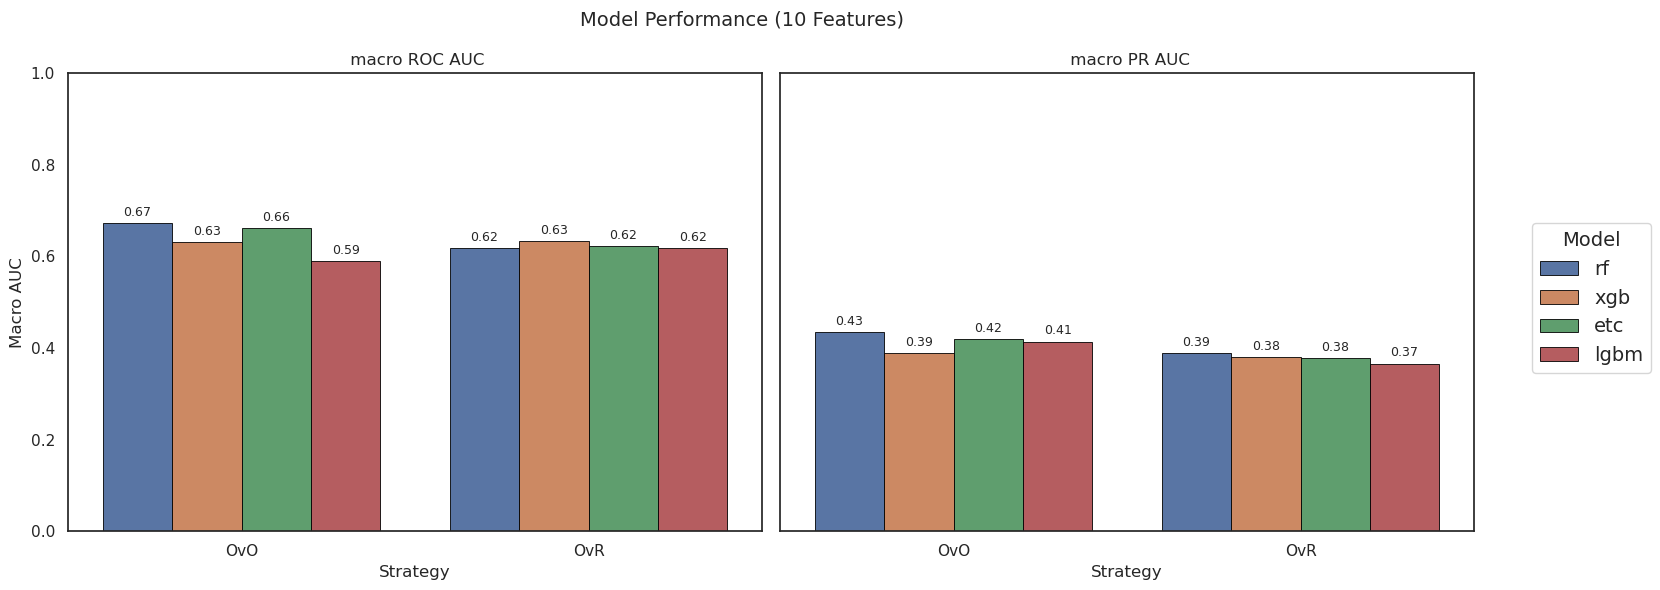

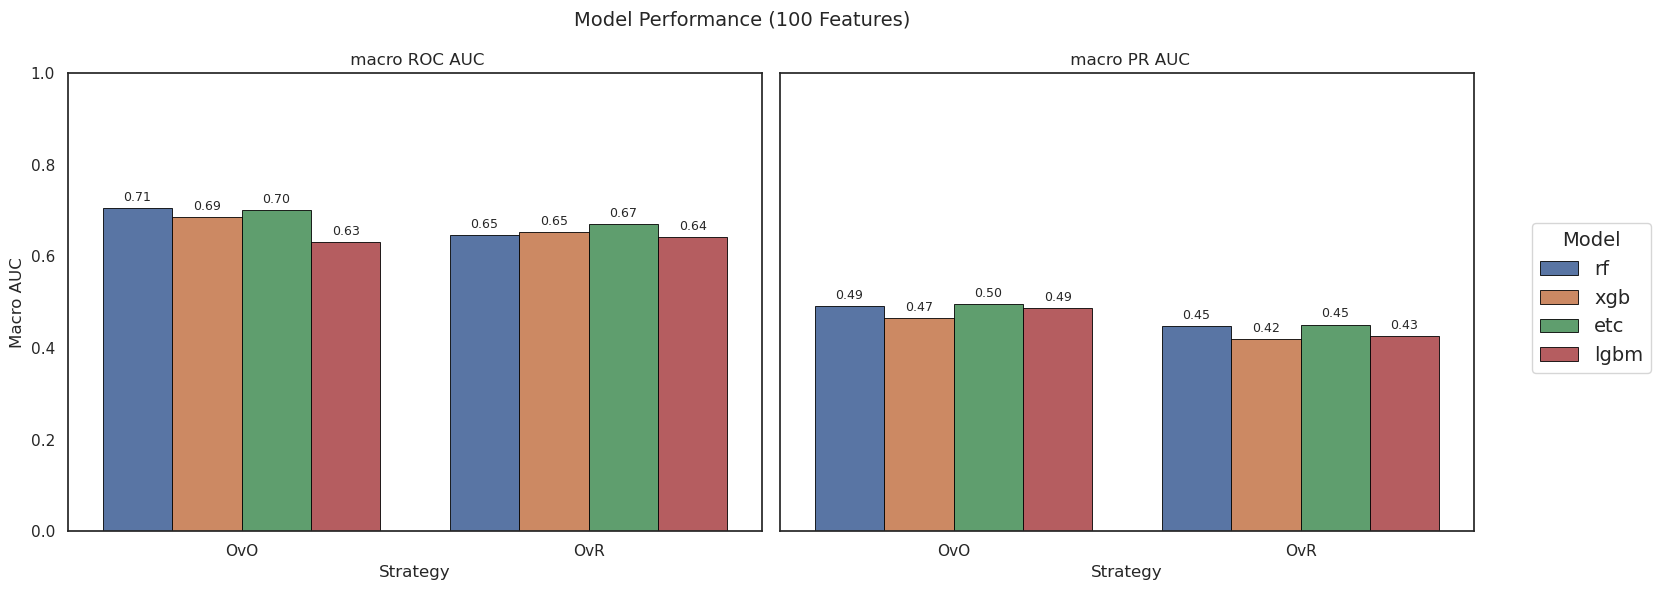

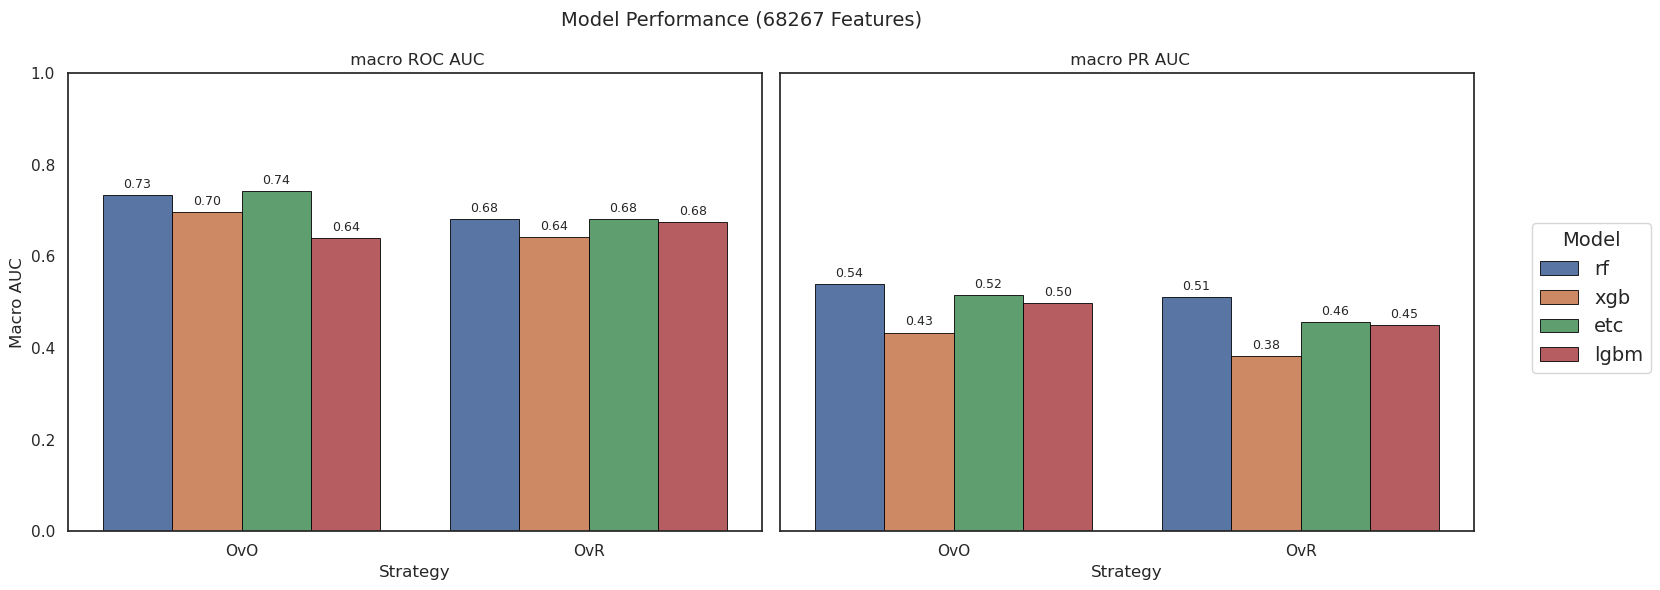

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(
    "HP_analysis_10_2025/benchmark/results/diff_models_on_combined(no grid).csv"
)

df = df[df['Class'] == 'Macro']

feature_sets = [10, 100, len(df_combined.columns)]
metrics = ['ROC AUC', 'PR AUC']

for feature in feature_sets:
    df_feat = df[df['Features (k)'] == feature]

    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

    for ax, metric in zip(axes, metrics):
        sns.barplot(
            data=df_feat,
            x='Type',        # OvR vs OvO
            y=metric,
            hue='Model',     # Models as hue
            ci=None,
            edgecolor='black',
            linewidth=0.6,
            ax=ax
        )

        ax.set_ylim(0, 1)
        ax.set_title(f" macro {metric}")
        ax.set_xlabel("Strategy")
        ax.set_ylabel("Macro AUC")

        # 🔹 Value labels
        for container in ax.containers:
            ax.bar_label(
                container,
                fmt="%.2f",
                padding=3,
                fontsize=9
            )

    # Shared legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        title="Model",
        title_fontsize=14,    
        prop={'size': 14},
        bbox_to_anchor=(1.02, 0.5),
        loc="center left"
    )
    axes[0].legend_.remove()
    axes[1].legend_.remove()

    fig.suptitle(f"Model Performance ({feature} Features)", fontsize=14)
    plt.tight_layout()
    plt.show()


# Testing TabPFN performance for 10, 20, 100 and 200 features on combined dataset

In [13]:
# Authenticate with Hugging Face Hub using the interactive widget.
# Required to access gated models like TabPFN.
from huggingface_hub import login
login()

n_seeds = 2
ks = [10, 20, 100, 200]  
result_path="HP_analysis_10_2025/benchmark/results/tabpfn_on_combined(no grid).csv"

# Check if the file exists and remove it once
if os.path.exists(result_path):
    print(f"File {result_path} exists. Deleting it to start fresh.")
    os.remove(result_path)
    
'''Although TabPFN can technically be trained in a one-vs-one fashion and yields strong binary performance, this setup 
is inconsistent with its design as a holistic multiclass prior model. Therefore, we report only OvR metrics for TabPFN.
'''
print(f"model: tabpfn ")
print("Combined dataset scores:")
run_classification(df_combined, y_target, ks, n_seeds,result_path,"combined", "tabpfn", None,use_grid=False)




model: tabpfn 
Combined dataset scores:
features(ks):  [10, 20, 100, 200]
seeds:  2
CV for seed 0 and 10 features
Performing One vs Rest classification
Macro ROC AUC (OvR): 0.6885
Macro Precision (OvR): 0.3585
Macro Recall (OvR): 0.3593
Macro F1 (OvR): 0.2693
Macro MCC (OvR): 0.0282
Macro PR AUC (OvR): 0.4521
Skipping One-vs-One metrics for TabPFN
{'Negative control vs Rest - Precision': 0.3089430894308943, 'Negative control vs Rest - Recall': 0.8444444444444444, 'Negative control vs Rest - F1': 0.4523809523809524, 'Negative control vs Rest - MCC': np.float64(-0.19030647618828472), 'Negative control vs Rest - PR AUC': np.float64(0.5215937371470658), 'Negative control vs Rest - ROC AUC': np.float64(0.6079900124843945), 'Patient vs Rest - Precision': 0.6, 'Patient vs Rest - Recall': 0.2, 'Patient vs Rest - F1': 0.3, 'Patient vs Rest - MCC': np.float64(0.3047535582858123), 'Patient vs Rest - PR AUC': np.float64(0.5523972628303063), 'Patient vs Rest - ROC AUC': np.float64(0.890196078431372

# PLotting TabPFN model performance on combined dataset

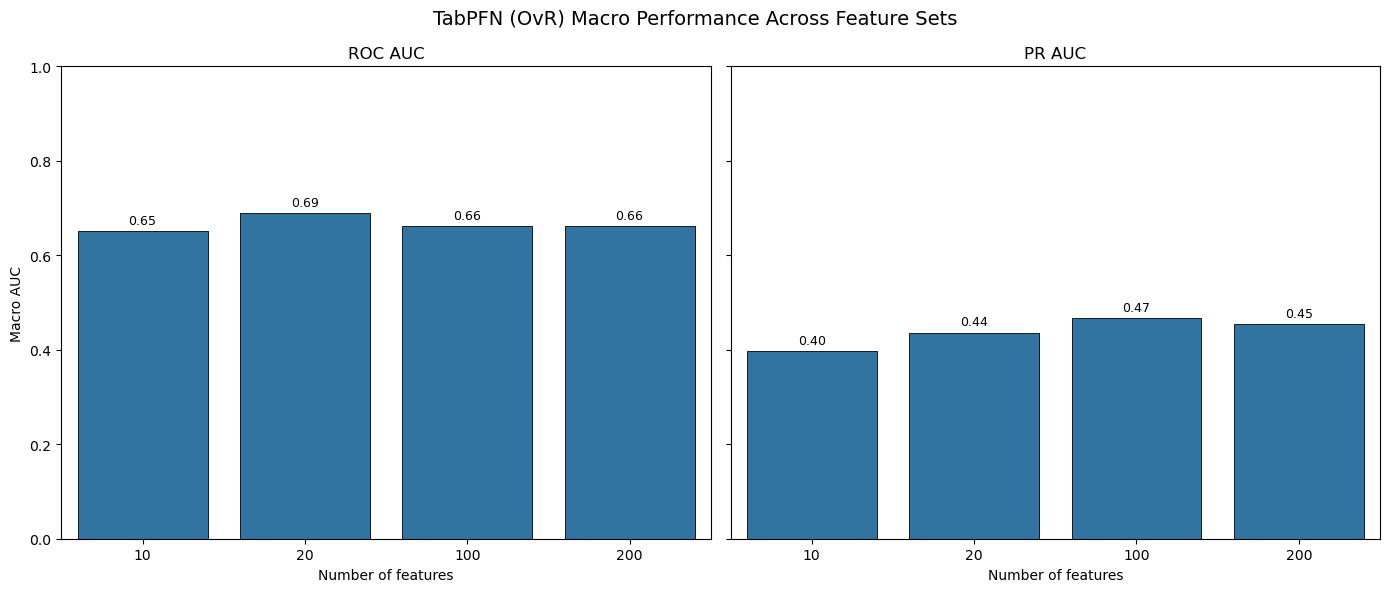

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load TabPFN results
df = pd.read_csv(
    "HP_analysis_10_2025/benchmark/results/tabpfn_on_combined(no grid).csv"
)

# Keep only Macro scores
df = df[df["Class"] == "Macro"]

metrics = ["ROC AUC", "PR AUC"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, metric in zip(axes, metrics):
    sns.barplot(
        data=df,
        x="Features (k)",
        y=metric,
        ci=None,
        edgecolor="black",
        linewidth=0.6,
        ax=ax
    )

    ax.set_title(metric)
    ax.set_xlabel("Number of features")
    ax.set_ylabel("Macro AUC")
    ax.set_ylim(0, 1)

    # 🔹 Value labels
    for container in ax.containers:
        ax.bar_label(
            container,
            fmt="%.2f",
            padding=3,
            fontsize=9
        )

fig.suptitle("TabPFN (OvR) Macro Performance Across Feature Sets", fontsize=14)
plt.tight_layout()
plt.show()


# comparing performance of all models including tabPFN for 10 and 100 feaures 

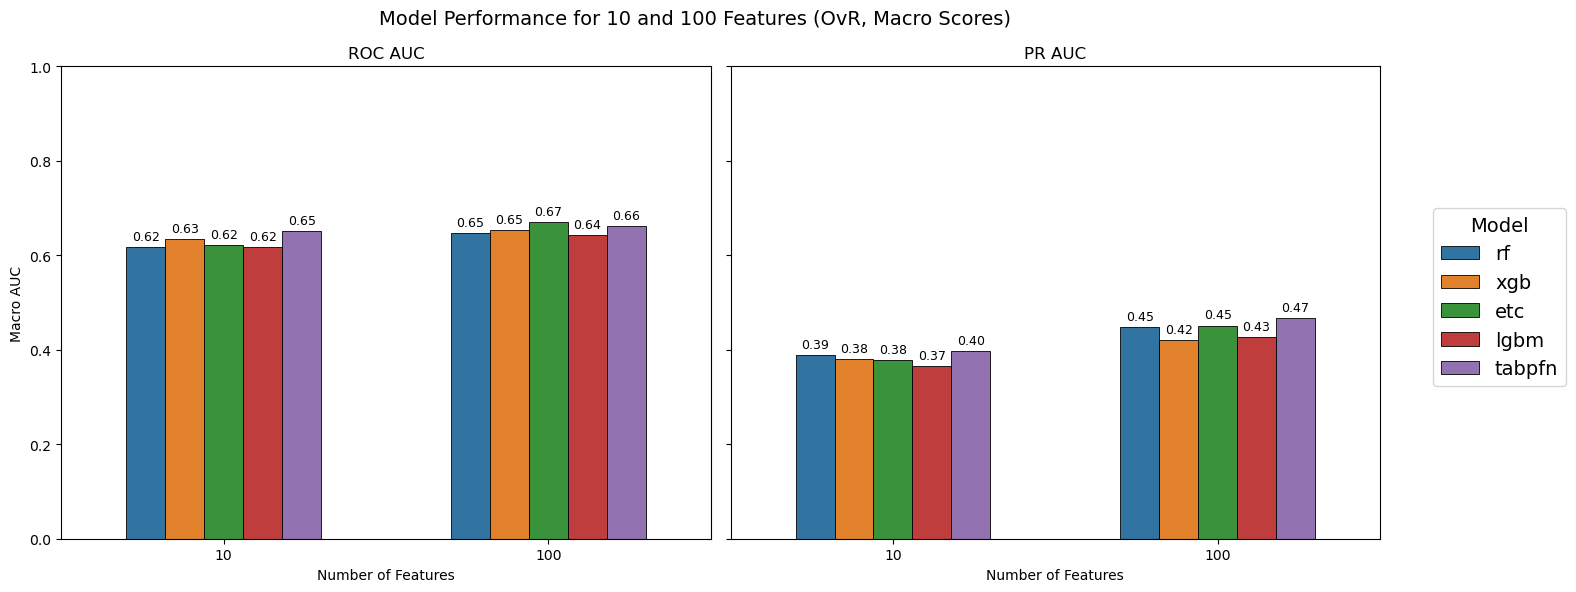

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the two CSV files
df_main = pd.read_csv(
    "HP_analysis_10_2025/benchmark/results/diff_models_on_combined(no grid).csv"
)
df_tabpfn = pd.read_csv(
    "HP_analysis_10_2025/benchmark/results/tabpfn_on_combined(no grid).csv"
)

# Filter for Macro scores only
df_main = df_main[df_main['Class'] == 'Macro']
df_tabpfn = df_tabpfn[df_tabpfn['Class'] == 'Macro']

# Keep only OvR from the main models
df_main = df_main[df_main['Type'] == 'OvR']

# Combine the data
df_comb = pd.concat([df_main, df_tabpfn], ignore_index=True)

# Hard-code feature sets to 10 and 100
df_comb = df_comb[df_comb['Features (k)'].isin([10, 100])]

metrics = ['ROC AUC', 'PR AUC']

# Create subplots: one per metric
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, metric in zip(axes, metrics):
    sns.barplot(
        data=df_comb,
        x='Features (k)',  # X-axis = 10 vs 100
        y=metric,
        hue='Model',        # Each model is a different color
        ci=None,
        edgecolor='black',
        linewidth=0.6,
        width=0.6,
        ax=ax
    )

    ax.set_ylim(0, 1)
    ax.set_title(metric)
    ax.set_xlabel("Number of Features")
    ax.set_ylabel("Macro AUC")

    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(
            container,
            fmt="%.2f",
            padding=3,
            fontsize=9
        )

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Model",
    title_fontsize=14,    
    prop={'size': 14},
    bbox_to_anchor=(1.02, 0.5),
    loc="center left"
)
axes[0].legend_.remove()
axes[1].legend_.remove()

fig.suptitle("Model Performance for 10 and 100 Features (OvR, Macro Scores)", fontsize=14)
plt.tight_layout()
plt.show()


###   TabPFN performs well on small feature sets, but it does not scale reliably to large feature spaces, whereas Random Forest consistently performs well and is robust as the number of features increases. So we further continue with RF 

# Evaluating RF with each dataset individually 

In [6]:
import os

n_seeds = 2
result_path = "HP_analysis_10_2025/benchmark/results/rf_on_each_dataset.csv"


# Check if the file exists and remove it once
if os.path.exists(result_path):
    print(f"File {result_path} exists. Deleting it to start fresh.")
    os.remove(result_path)

# Looping through  datasets to get name and total num of features of each individual dataset
for omic in raw_data:  # raw_data is list of datasets loaded earlier
    name = omic['name']
    df = omic['df']
    ks = [10, len(df.columns)]   
    print(f"Running RF on dataset: {name}")
   
    run_classification(df, y_target, ks, n_seeds, result_path, name, "rf", None, use_grid=False)

   
   

Running RF on dataset: SCFA
features(ks):  [10, 27]
seeds:  2
CV for seed 0 and 10 features
Performing One vs Rest classification
Macro ROC AUC (OvR): 0.5967
Macro Precision (OvR): 0.3019
Macro Recall (OvR): 0.3444
Macro F1 (OvR): 0.2430
Macro MCC (OvR): 0.0200
Macro PR AUC (OvR): 0.3122
Performing One vs One classification
Macro ROC AUC (OvO): 0.6478
Macro Precision (OvO): 0.5288
Macro Recall (OvO): 0.1667
Macro F1 (OvO): 0.2021
Macro MCC (OvO): 0.1116
Macro PR AUC (OvO): 0.3554
{'Negative control vs Rest - Precision': 0.32231404958677684, 'Negative control vs Rest - Recall': 0.8666666666666667, 'Negative control vs Rest - F1': 0.46987951807228917, 'Negative control vs Rest - MCC': np.float64(-0.08725262333595465), 'Negative control vs Rest - PR AUC': np.float64(0.40980406054049284), 'Negative control vs Rest - ROC AUC': np.float64(0.5544319600499377), 'Patient vs Rest - Precision': 0.25, 'Patient vs Rest - Recall': 0.06666666666666667, 'Patient vs Rest - F1': 0.10526315789473684, 'Pa

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvR): 0.6538
Macro Precision (OvR): 0.1136
Macro Recall (OvR): 0.3333
Macro F1 (OvR): 0.1695
Macro MCC (OvR): 0.0071
Macro PR AUC (OvR): 0.3636
Performing One vs One classification
Macro ROC AUC (OvO): 0.6634
Macro Precision (OvO): 0.5714
Macro Recall (OvO): 0.1333
Macro F1 (OvO): 0.1932
Macro MCC (OvO): 0.1778
Macro PR AUC (OvO): 0.4146
{'Negative control vs Rest - Precision': 0.3409090909090909, 'Negative control vs Rest - Recall': 1.0, 'Negative control vs Rest - F1': 0.5084745762711864, 'Negative control vs Rest - MCC': np.float64(0.08752644427483217), 'Negative control vs Rest - PR AUC': np.float64(0.3805655951089526), 'Negative control vs Rest - ROC AUC': np.float64(0.6177278401997504), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': 0.0, 'Patient vs Rest - PR AUC': np.float64(0.45503743860042833), 'Patient vs Rest - ROC AUC': np.float64(0.7518207282913165), 'Positive control vs Rest - Preci

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.5990
Macro Precision (OvO): 0.2167
Macro Recall (OvO): 0.0556
Macro F1 (OvO): 0.0863
Macro MCC (OvO): 0.0164
Macro PR AUC (OvO): 0.3080
{'Negative control vs Rest - Precision': 0.3228346456692913, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.47674418604651164, 'Negative control vs Rest - MCC': np.float64(-0.11712244581657971), 'Negative control vs Rest - PR AUC': np.float64(0.4274371074291892), 'Negative control vs Rest - ROC AUC': np.float64(0.6113607990012484), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': np.float64(-0.04370188612670306), 'Patient vs Rest - PR AUC': np.float64(0.23663766911817244), 'Patient vs Rest - ROC AUC': np.float64(0.761344537815126), 'Positive control vs Rest - Precision': 0.2, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.05714285714285714, 'Positive control vs Rest -

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.6741
Macro Precision (OvO): 0.5000
Macro Recall (OvO): 0.0444
Macro F1 (OvO): 0.0809
Macro MCC (OvO): 0.1066
Macro PR AUC (OvO): 0.4035
{'Negative control vs Rest - Precision': 0.3203125, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.47398843930635837, 'Negative control vs Rest - MCC': np.float64(-0.15167002781255928), 'Negative control vs Rest - PR AUC': np.float64(0.5333286222249953), 'Negative control vs Rest - ROC AUC': np.float64(0.6779026217228464), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': np.float64(-0.03078550828004397), 'Patient vs Rest - PR AUC': np.float64(0.43425256577109117), 'Patient vs Rest - ROC AUC': np.float64(0.823529411764706), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest - MCC': np.float64(-0.10573873360945339), 

# Plot "Macro scores" for ROC AUC and PR AUC using RF model for 10 and all features of each dataset 

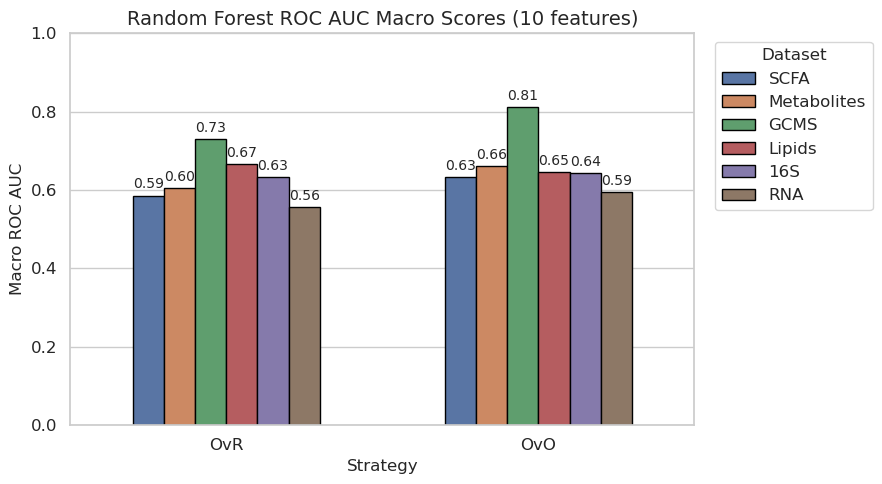

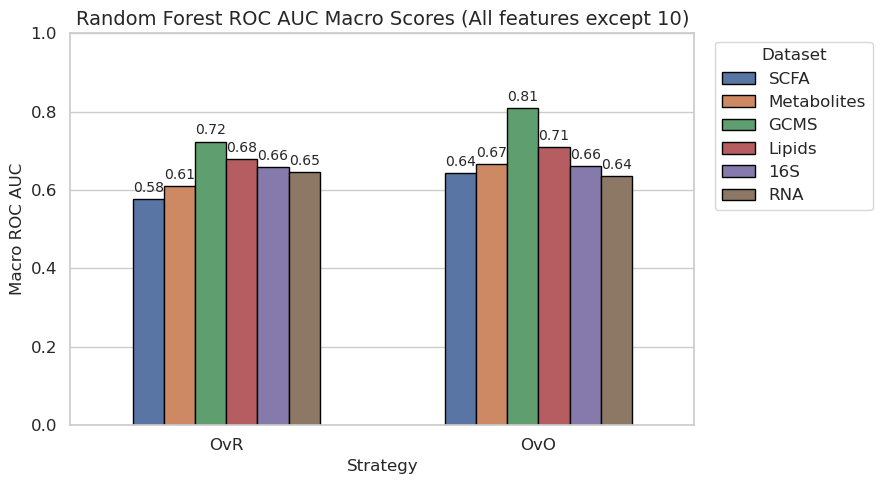

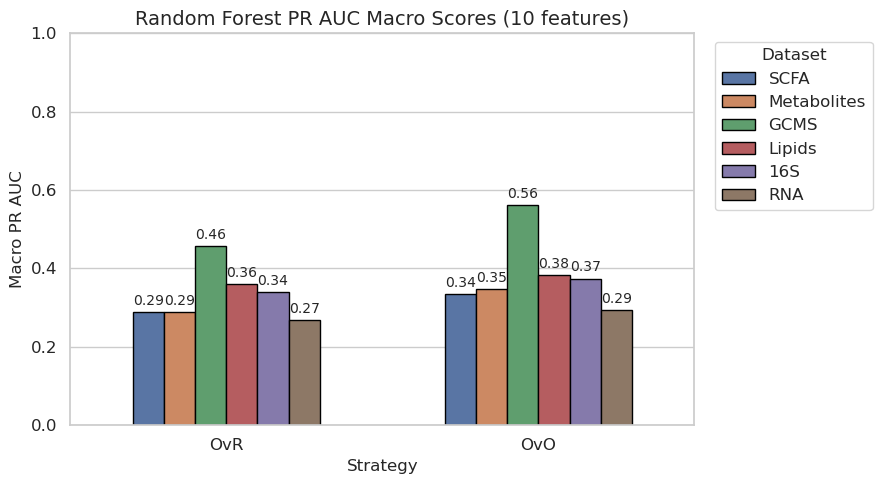

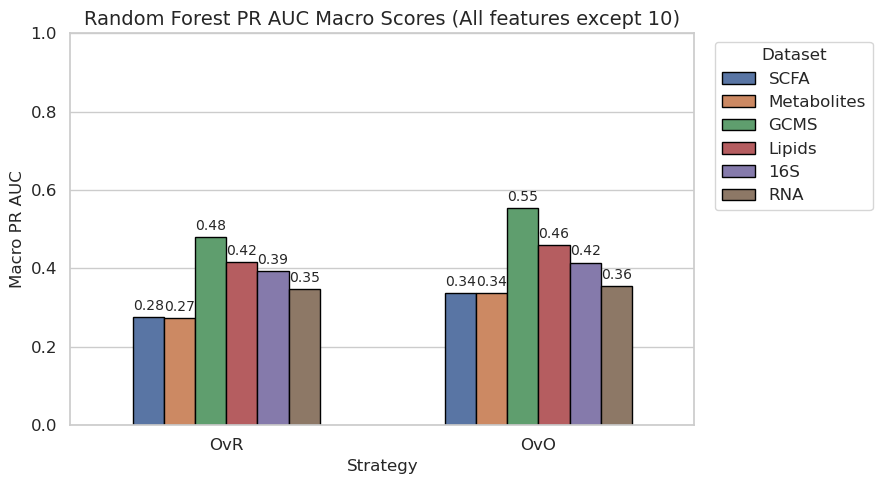

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Load RF results
df = pd.read_csv("HP_analysis_10_2025/benchmark/results/rf_on_each_dataset.csv")

# Keep ONLY Macro class
df_macro = df[df["Class"] == "Macro"]

def plot_macro_metric_single_plot(metric, title, num_features=None, all_except_10=False):
    """
    Single plot: x-axis = OvR/OvO, y-axis = macro metric, hue = dataset/model
    """
    if all_except_10:
        df_plot = df_macro[df_macro["Features (k)"] != 10]
        feature_label = "All features except 10"
    else:
        df_plot = df_macro[df_macro["Features (k)"] == 10]
        feature_label = f"{num_features} features"

    fig, ax = plt.subplots(figsize=(9, 5))

    # Plot bars with OvR and OvO on x-axis
    sns.barplot(
        data=df_plot,
        x="Type",      # OvR / OvO
        y=metric,
        hue="Label",   # Models/Datasets
        edgecolor="black",
        ci=None,
        width=0.6,
        ax=ax
    )

    ax.set_ylim(0, 1)
    ax.set_ylabel(f"Macro {metric}", fontsize=12)
    ax.set_xlabel("Strategy", fontsize=12)
    ax.tick_params(axis="x", rotation=0, labelsize=12)
    ax.tick_params(axis="y", labelsize=12)

    # Add numerical values on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)

    # Title
    ax.set_title(f"{title} ({feature_label})", fontsize=14)

    # Legend outside
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, labels,
        title="Dataset",
        title_fontsize=12,
        prop={'size': 12},
        bbox_to_anchor=(1.02, 1),
        loc="upper left"
    )

    plt.tight_layout()
    plt.show()


# Metrics to plot
metrics = ["ROC AUC", "PR AUC"]

for metric in metrics:
    # Plot for 10 features
    plot_macro_metric_single_plot(metric, f"Random Forest {metric} Macro Scores", num_features=10)
    # Plot for all other features
    plot_macro_metric_single_plot(metric, f"Random Forest {metric} Macro Scores", all_except_10=True)


# Plot ROC AUC and PR AUC scores for rf model on each dataset for 10 and all features

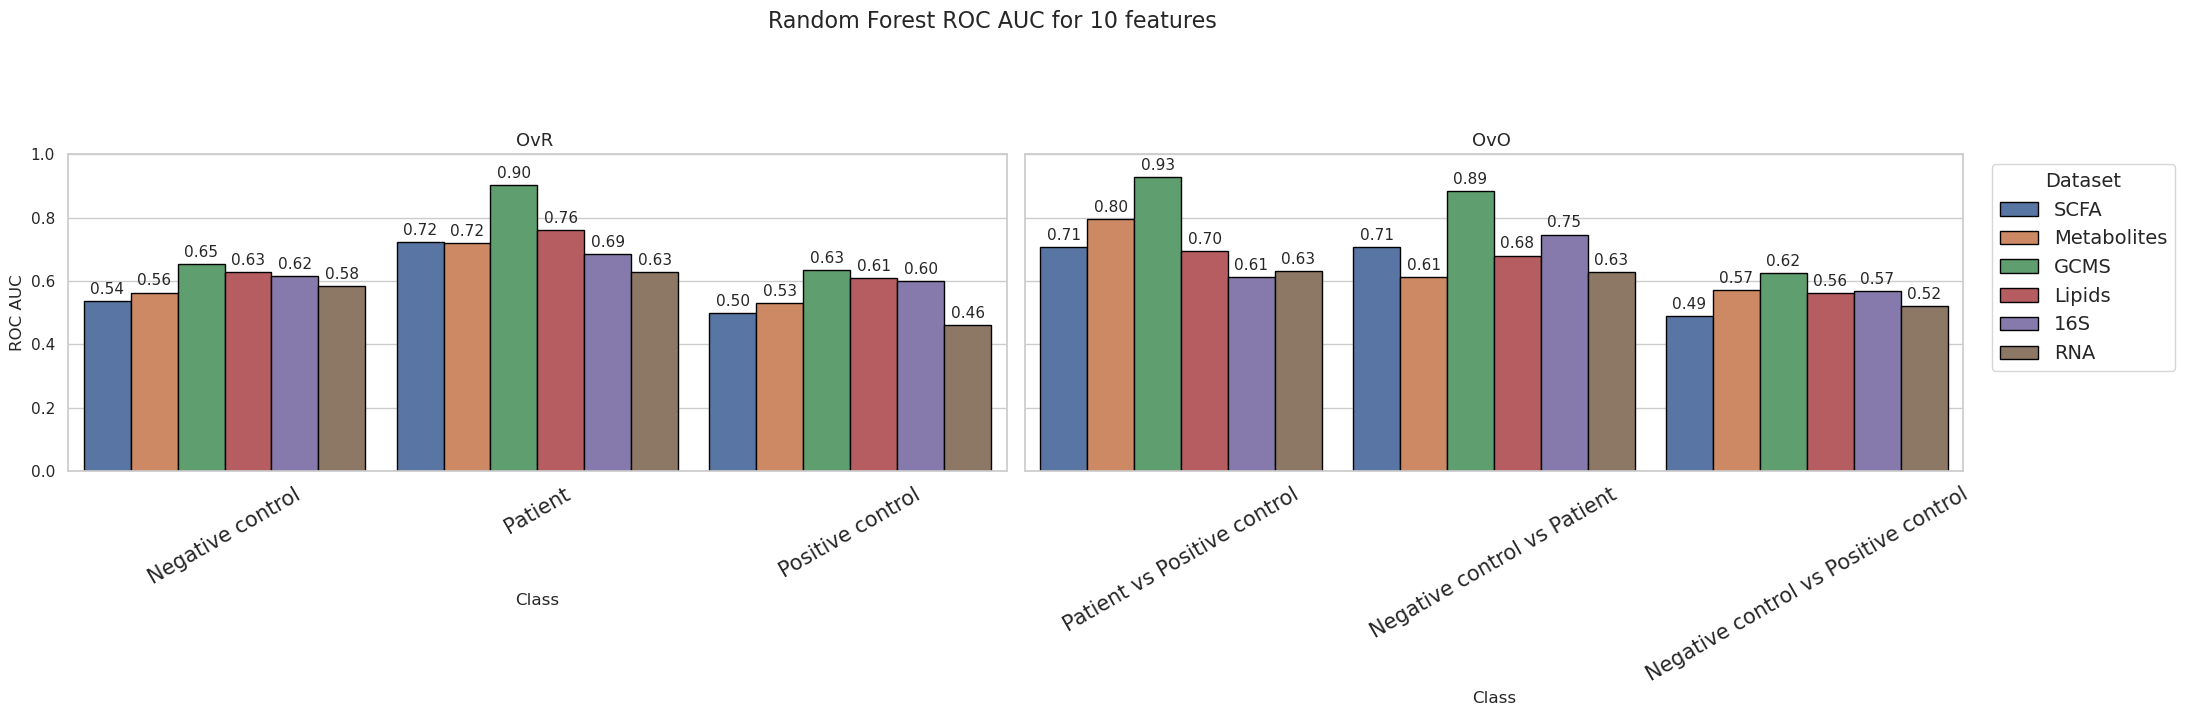

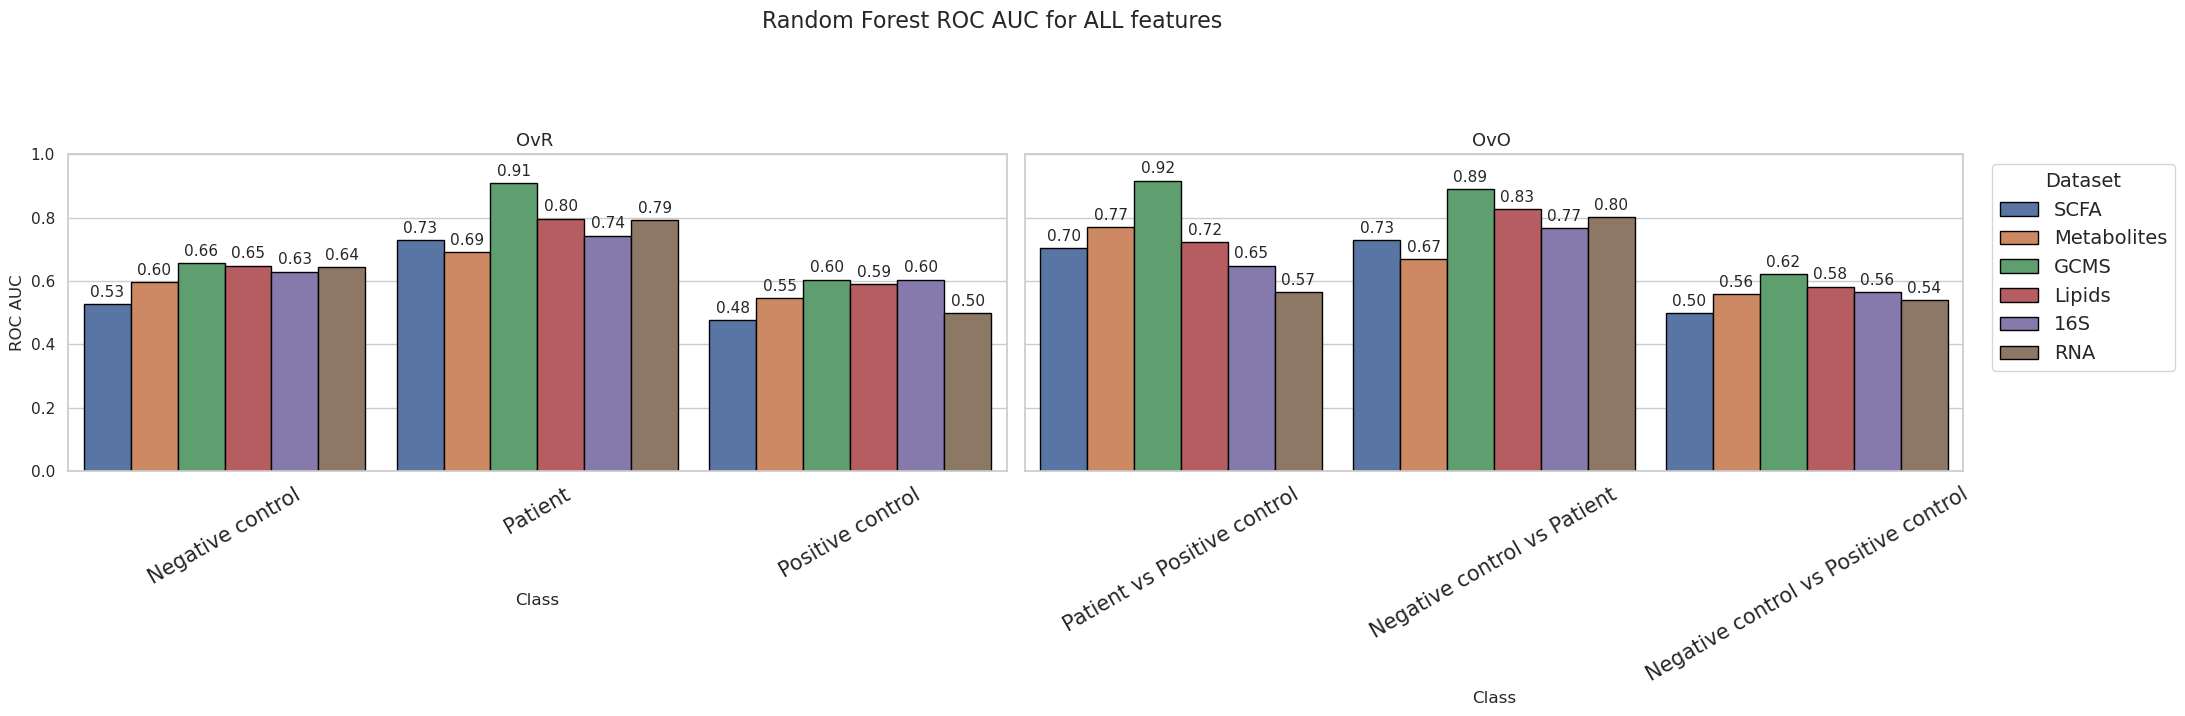

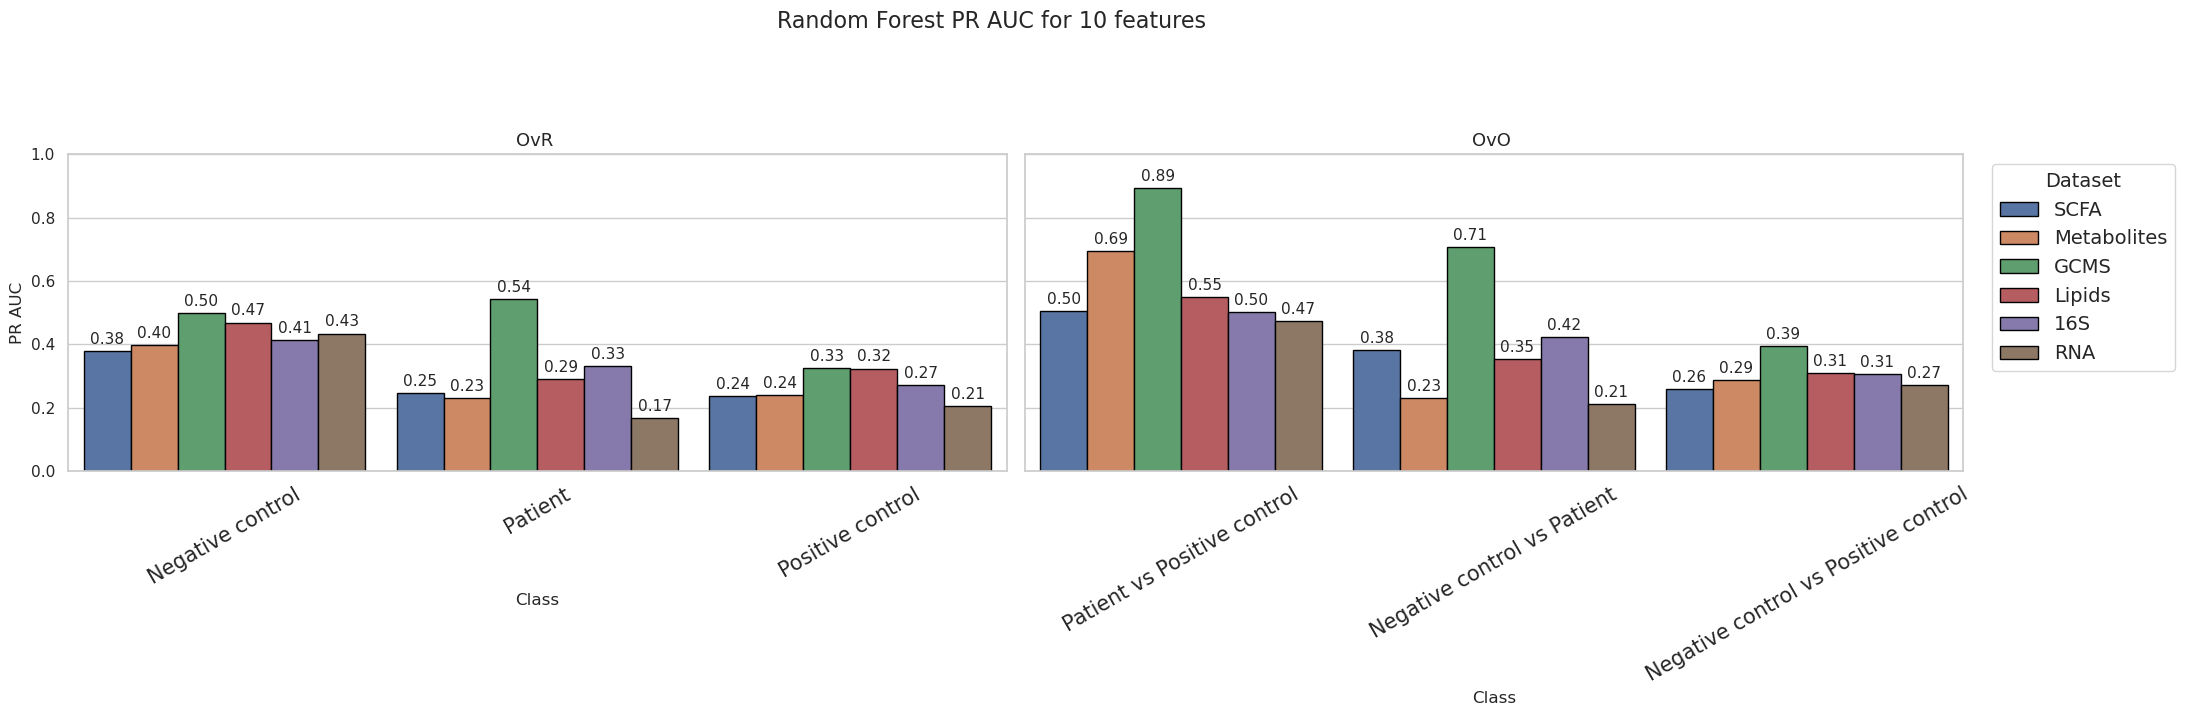

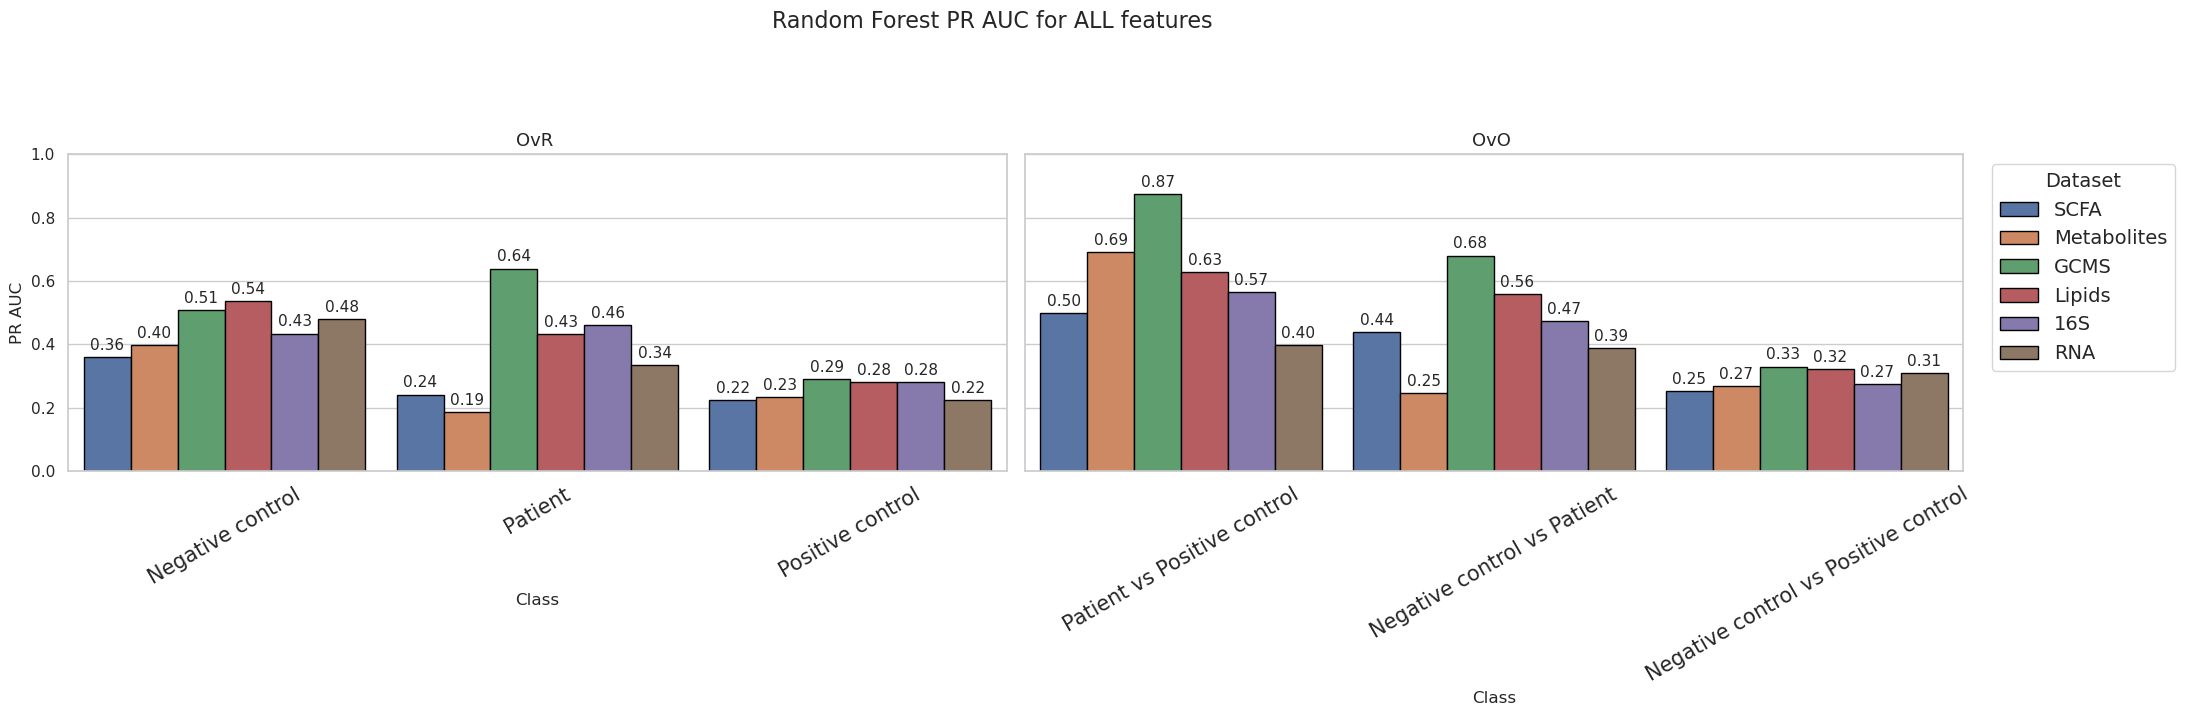

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Load RF results
df = pd.read_csv("HP_analysis_10_2025/benchmark/results/rf_on_each_dataset.csv")

# Keep ONLY non-Macro classes
df_non_macro = df[df["Class"] != "Macro"]

# Classes
classes = df_non_macro["Class"].unique()

def plot_metric_by_class(metric, title, num_features=None, all_except_10=False):
    """
    If num_features is given, filter by that exact number.
    If all_except_10=True, take all features except 10.
    """
    if all_except_10:
        df_plot = df_non_macro[df_non_macro["Features (k)"] != 10]
        #feature_label = "All features "
    else:
        df_plot = df_non_macro[df_non_macro["Features (k)"] == 10]
        #feature_label = f"{num_features} features"
    
    fig, axes = plt.subplots(1, 2, figsize=(25, 7), sharey=True)

    for ax, t in zip(axes, ["OvR", "OvO"]):
        sns.barplot(
            data=df_plot[df_plot["Type"] == t],
            x="Class",
            y=metric,
            hue="Label",
            edgecolor="black",
            ax=ax,
            ci=None,
            width=0.9
        )

        ax.set_title(f"{t} ", fontsize=13)
        ax.set_xlabel("Class")
        ax.set_ylim(0, 1)
        ax.tick_params(axis="x", rotation=30,labelsize=15)
        ax.set_ylabel(metric)
        for container in ax.containers:
            ax.bar_label(container, fmt="%.2f", padding=3, fontsize=11)


    # Properly aligned main title
    fig.suptitle(title, fontsize=16, y=1.02, x=0.4)

    # Put legend outside
    axes[1].legend(
        title="Dataset",
        title_fontsize=14,    # Font size of legend title
        prop={'size': 14},
        bbox_to_anchor=(1.02, 1),
        loc="upper left"
    )

    # Remove duplicate legend
    axes[0].get_legend().remove()

    plt.tight_layout(rect=[0, 0, 0.88, 0.93])
    plt.show()


# Metrics to plot
metrics = ["ROC AUC", "PR AUC"]

for metric in metrics:
    # Plot for 10 features
    plot_metric_by_class(metric, f"Random Forest {metric} for 10 features", num_features=10)
    # Plot for all other features
    plot_metric_by_class(metric, f"Random Forest {metric} for ALL features", all_except_10=True)


# 2 out of n Dataset combinations

In [52]:
import itertools
import pandas as pd

# Exclude the already combined dataset at the end
num_datasets = len(tss_datasets) - 1

all_combinations = []  # Stores the actual dataframes for each combination
all_combination_names = []  # Stores the names of datasets in each combination

# Generate all 2-dataset combinations
for combo_indices in itertools.combinations(range(num_datasets), 2):
    combination_df = pd.concat([tss_datasets[i] for i in combo_indices], axis=1)
    all_combinations.append(combination_df) # Store the dataframe separately

     # Store the names of the datasets in this combination
    all_combination_names.append([dataset_names[i] for i in combo_indices]) 
print("total combinations : ", len(all_combination_names))
print(all_combination_names)

total combinations :  15
[['SCFA', 'Metabolites'], ['SCFA', 'GCMS'], ['SCFA', 'Lipids'], ['SCFA', '16S'], ['SCFA', 'RNA'], ['Metabolites', 'GCMS'], ['Metabolites', 'Lipids'], ['Metabolites', '16S'], ['Metabolites', 'RNA'], ['GCMS', 'Lipids'], ['GCMS', '16S'], ['GCMS', 'RNA'], ['Lipids', '16S'], ['Lipids', 'RNA'], ['16S', 'RNA']]


# Evaluating the best model from above (RF) across different dataset combinations.

In [53]:
n_seeds = 2
result_path = "HP_analysis_10_2025/benchmark/results/combinations_of_2_datasets(no_grid).csv"

# Check if the file exists and remove it once
if os.path.exists(result_path):
    print(f"File {result_path} exists. Deleting it to start fresh.")
    os.remove(result_path)
    
# Looping through  datasets combinations   to get name and total num of features 
for combo_df, combo_names in zip(all_combinations, all_combination_names):
    combo_label = "+".join(combo_names)  # e.g., "metabolomics+transcriptomics"
    ks = [10, len(combo_df.columns)]
    print(f"\nRunning rf model on combination: {combo_label}")
    run_classification(combo_df, y_target, ks, n_seeds, result_path, combo_label, "rf", None, use_grid=False)

File HP_analysis_10_2025/benchmark/results/combinations_of_2_datasets(no_grid).csv exists. Deleting it to start fresh.

Running rf model on combination: SCFA+Metabolites
features(ks):  [10, 466]
seeds:  2
CV for seed 0 and 10 features
Performing One vs Rest classification
Macro ROC AUC (OvR): 0.6356
Macro Precision (OvR): 0.3713
Macro Recall (OvR): 0.4074
Macro F1 (OvR): 0.3406
Macro MCC (OvR): 0.0927
Macro PR AUC (OvR): 0.3791
Performing One vs One classification
Macro ROC AUC (OvO): 0.6711
Macro Precision (OvO): 0.6087
Macro Recall (OvO): 0.3444
Macro F1 (OvO): 0.4342
Macro MCC (OvO): 0.3394
Macro PR AUC (OvO): 0.4501
{'Negative control vs Rest - Precision': 0.3063063063063063, 'Negative control vs Rest - Recall': 0.7555555555555555, 'Negative control vs Rest - F1': 0.4358974358974359, 'Negative control vs Rest - MCC': np.float64(-0.13728966731595585), 'Negative control vs Rest - PR AUC': np.float64(0.4493340661154085), 'Negative control vs Rest - ROC AUC': np.float64(0.5770287141073

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvR): 0.6940
Macro Precision (OvR): 0.3431
Macro Recall (OvR): 0.4074
Macro F1 (OvR): 0.3066
Macro MCC (OvR): 0.0868
Macro PR AUC (OvR): 0.4522
Performing One vs One classification
Macro ROC AUC (OvO): 0.7191
Macro Precision (OvO): 0.4811
Macro Recall (OvO): 0.3111
Macro F1 (OvO): 0.3757
Macro MCC (OvO): 0.3089
Macro PR AUC (OvO): 0.4890
{'Negative control vs Rest - Precision': 0.31496062992125984, 'Negative control vs Rest - Recall': 0.8888888888888888, 'Negative control vs Rest - F1': 0.46511627906976744, 'Negative control vs Rest - MCC': np.float64(-0.18813786545197195), 'Negative control vs Rest - PR AUC': np.float64(0.5163625699558035), 'Negative control vs Rest - ROC AUC': np.float64(0.6340823970037454), 'Patient vs Rest - Precision': 0.7142857142857143, 'Patient vs Rest - Recall': 0.3333333333333333, 'Patient vs Rest - F1': 0.45454545454545453, 'Patient vs Rest - MCC': np.float64(0.44851653370375394), 'Patient vs Rest - PR AUC': np.float64(0.4904518201419965), 'Pa

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.6567
Macro Precision (OvO): 0.1333
Macro Recall (OvO): 0.0444
Macro F1 (OvO): 0.0667
Macro MCC (OvO): -0.0086
Macro PR AUC (OvO): 0.4007
{'Negative control vs Rest - Precision': 0.328, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.4823529411764706, 'Negative control vs Rest - MCC': np.float64(-0.06171543212481474), 'Negative control vs Rest - PR AUC': np.float64(0.5185260890642395), 'Negative control vs Rest - ROC AUC': np.float64(0.6764044943820224), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': np.float64(-0.03078550828004397), 'Patient vs Rest - PR AUC': np.float64(0.5008902675645358), 'Patient vs Rest - ROC AUC': np.float64(0.8862745098039216), 'Positive control vs Rest - Precision': 0.125, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.05263157894736842, 'Positive control vs Rest - MCC': np.f

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.6590
Macro Precision (OvO): 0.1667
Macro Recall (OvO): 0.0222
Macro F1 (OvO): 0.0392
Macro MCC (OvO): -0.0381
Macro PR AUC (OvO): 0.4044
{'Negative control vs Rest - Precision': 0.3178294573643411, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.47126436781609193, 'Negative control vs Rest - MCC': np.float64(-0.19349924352143671), 'Negative control vs Rest - PR AUC': np.float64(0.5809432432301296), 'Negative control vs Rest - ROC AUC': np.float64(0.6529338327091136), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': np.float64(-0.03078550828004397), 'Patient vs Rest - PR AUC': np.float64(0.35348029765911765), 'Patient vs Rest - ROC AUC': np.float64(0.784593837535014), 'Positive control vs Rest - Precision': 0.25, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.058823529411764705, 'Positive control vs Res

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvR): 0.6985
Macro Precision (OvR): 0.2361
Macro Recall (OvR): 0.3778
Macro F1 (OvR): 0.2507
Macro MCC (OvR): 0.0631
Macro PR AUC (OvR): 0.4403
Performing One vs One classification
Macro ROC AUC (OvO): 0.7649
Macro Precision (OvO): 0.7685
Macro Recall (OvO): 0.3333
Macro F1 (OvO): 0.4028
Macro MCC (OvO): 0.3729
Macro PR AUC (OvO): 0.5149
{'Negative control vs Rest - Precision': 0.3333333333333333, 'Negative control vs Rest - Recall': 0.9333333333333333, 'Negative control vs Rest - F1': 0.49122807017543857, 'Negative control vs Rest - MCC': np.float64(-0.02090344009344693), 'Negative control vs Rest - PR AUC': np.float64(0.4988419294186283), 'Negative control vs Rest - ROC AUC': np.float64(0.650187265917603), 'Patient vs Rest - Precision': 0.375, 'Patient vs Rest - Recall': 0.2, 'Patient vs Rest - F1': 0.2608695652173913, 'Patient vs Rest - MCC': np.float64(0.2102324405785859), 'Patient vs Rest - PR AUC': np.float64(0.45737121852541834), 'Patient vs Rest - ROC AUC': np.fl

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.7439
Macro Precision (OvO): 0.3929
Macro Recall (OvO): 0.2000
Macro F1 (OvO): 0.2648
Macro MCC (OvO): 0.2095
Macro PR AUC (OvO): 0.4351
{'Negative control vs Rest - Precision': 0.31746031746031744, 'Negative control vs Rest - Recall': 0.8888888888888888, 'Negative control vs Rest - F1': 0.4678362573099415, 'Negative control vs Rest - MCC': np.float64(-0.1542872959278226), 'Negative control vs Rest - PR AUC': np.float64(0.45443189213722696), 'Negative control vs Rest - ROC AUC': np.float64(0.6223470661672907), 'Patient vs Rest - Precision': 0.7142857142857143, 'Patient vs Rest - Recall': 0.3333333333333333, 'Patient vs Rest - F1': 0.45454545454545453, 'Patient vs Rest - MCC': np.float64(0.44851653370375394), 'Patient vs Rest - PR AUC': np.float64(0.3876753489127239), 'Patient vs Rest - ROC AUC': np.float64(0.830812324929972), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive contr

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvR): 0.6864
Macro Precision (OvR): 0.3431
Macro Recall (OvR): 0.4074
Macro F1 (OvR): 0.3066
Macro MCC (OvR): 0.0868
Macro PR AUC (OvR): 0.4606
Performing One vs One classification
Macro ROC AUC (OvO): 0.7344
Macro Precision (OvO): 0.5000
Macro Recall (OvO): 0.2667
Macro F1 (OvO): 0.3478
Macro MCC (OvO): 0.2920
Macro PR AUC (OvO): 0.4906
{'Negative control vs Rest - Precision': 0.31496062992125984, 'Negative control vs Rest - Recall': 0.8888888888888888, 'Negative control vs Rest - F1': 0.46511627906976744, 'Negative control vs Rest - MCC': np.float64(-0.18813786545197195), 'Negative control vs Rest - PR AUC': np.float64(0.5372792915455415), 'Negative control vs Rest - ROC AUC': np.float64(0.6368289637952559), 'Patient vs Rest - Precision': 0.7142857142857143, 'Patient vs Rest - Recall': 0.3333333333333333, 'Patient vs Rest - F1': 0.45454545454545453, 'Patient vs Rest - MCC': np.float64(0.44851653370375394), 'Patient vs Rest - PR AUC': np.float64(0.5699247375376871), 'Pa

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvR): 0.6987
Macro Precision (OvR): 0.4385
Macro Recall (OvR): 0.3926
Macro F1 (OvR): 0.2965
Macro MCC (OvR): 0.0825
Macro PR AUC (OvR): 0.4349
Performing One vs One classification
Macro ROC AUC (OvO): 0.7331
Macro Precision (OvO): 0.6000
Macro Recall (OvO): 0.2667
Macro F1 (OvO): 0.3652
Macro MCC (OvO): 0.3412
Macro PR AUC (OvO): 0.4825
{'Negative control vs Rest - Precision': 0.3153846153846154, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.4685714285714286, 'Negative control vs Rest - MCC': np.float64(-0.24668745581139884), 'Negative control vs Rest - PR AUC': np.float64(0.5048267491441913), 'Negative control vs Rest - ROC AUC': np.float64(0.6525593008739076), 'Patient vs Rest - Precision': 1.0, 'Patient vs Rest - Recall': 0.26666666666666666, 'Patient vs Rest - F1': 0.42105263157894735, 'Patient vs Rest - MCC': np.float64(0.49406736797987794), 'Patient vs Rest - PR AUC': np.float64(0.514045044096939), 'Patient vs Rest - R

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.7241
Macro Precision (OvO): 0.2667
Macro Recall (OvO): 0.0889
Macro F1 (OvO): 0.1333
Macro MCC (OvO): 0.0806
Macro PR AUC (OvO): 0.5081
{'Negative control vs Rest - Precision': 0.3203125, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.47398843930635837, 'Negative control vs Rest - MCC': np.float64(-0.15167002781255928), 'Negative control vs Rest - PR AUC': np.float64(0.569862008229523), 'Negative control vs Rest - ROC AUC': np.float64(0.6504369538077404), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': np.float64(-0.03078550828004397), 'Patient vs Rest - PR AUC': np.float64(0.4942652283656482), 'Patient vs Rest - ROC AUC': np.float64(0.8717086834733894), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest - MCC': np.float64(-0.10573873360945339), '

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.7577
Macro Precision (OvO): 0.5278
Macro Recall (OvO): 0.3111
Macro F1 (OvO): 0.3810
Macro MCC (OvO): 0.3394
Macro PR AUC (OvO): 0.5340
{'Negative control vs Rest - Precision': 0.29508196721311475, 'Negative control vs Rest - Recall': 0.8, 'Negative control vs Rest - F1': 0.4311377245508982, 'Negative control vs Rest - MCC': np.float64(-0.27504416162765494), 'Negative control vs Rest - PR AUC': np.float64(0.5898840367716176), 'Negative control vs Rest - ROC AUC': np.float64(0.6910112359550561), 'Patient vs Rest - Precision': 0.6, 'Patient vs Rest - Recall': 0.4, 'Patient vs Rest - F1': 0.48, 'Patient vs Rest - MCC': np.float64(0.4395899910828648), 'Patient vs Rest - PR AUC': np.float64(0.5440263166761451), 'Patient vs Rest - ROC AUC': np.float64(0.8229691876750701), 'Positive control vs Rest - Precision': 0.5, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.0625, 'Positive control vs Rest - MCC': np.float64(0.081536573

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.7009
Macro Precision (OvO): 0.2500
Macro Recall (OvO): 0.0556
Macro F1 (OvO): 0.0898
Macro MCC (OvO): 0.0365
Macro PR AUC (OvO): 0.4182
{'Negative control vs Rest - Precision': 0.3253968253968254, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.47953216374269003, 'Negative control vs Rest - MCC': np.float64(-0.08759536801063475), 'Negative control vs Rest - PR AUC': np.float64(0.4998296832860145), 'Negative control vs Rest - ROC AUC': np.float64(0.6157303370786518), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': np.float64(-0.03078550828004397), 'Patient vs Rest - PR AUC': np.float64(0.4337081399510245), 'Patient vs Rest - ROC AUC': np.float64(0.8473389355742298), 'Positive control vs Rest - Precision': 0.14285714285714285, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.05405405405405406, 'Positive c

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.6644
Macro Precision (OvO): 0.3056
Macro Recall (OvO): 0.0444
Macro F1 (OvO): 0.0755
Macro MCC (OvO): 0.0328
Macro PR AUC (OvO): 0.3898
{'Negative control vs Rest - Precision': 0.32558139534883723, 'Negative control vs Rest - Recall': 0.9333333333333333, 'Negative control vs Rest - F1': 0.4827586206896552, 'Negative control vs Rest - MCC': np.float64(-0.11012657911027106), 'Negative control vs Rest - PR AUC': np.float64(0.5095727118793851), 'Negative control vs Rest - ROC AUC': np.float64(0.6369538077403245), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': np.float64(-0.03078550828004397), 'Patient vs Rest - PR AUC': np.float64(0.3027557366809851), 'Patient vs Rest - ROC AUC': np.float64(0.8221288515406162), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest - MCC': np.float64(-0.09421114395

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.7325
Macro Precision (OvO): 0.0000
Macro Recall (OvO): 0.0000
Macro F1 (OvO): 0.0000
Macro MCC (OvO): -0.0686
Macro PR AUC (OvO): 0.4619
{'Negative control vs Rest - Precision': 0.3228346456692913, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.47674418604651164, 'Negative control vs Rest - MCC': np.float64(-0.11712244581657971), 'Negative control vs Rest - PR AUC': np.float64(0.5661268105841849), 'Negative control vs Rest - ROC AUC': np.float64(0.6428214731585519), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': np.float64(-0.03078550828004397), 'Patient vs Rest - PR AUC': np.float64(0.6042914076374452), 'Patient vs Rest - ROC AUC': np.float64(0.8806722689075631), 'Positive control vs Rest - Precision': 0.16666666666666666, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.05555555555555555, 'Positive 

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvR): 0.7149
Macro Precision (OvR): 0.1623
Macro Recall (OvR): 0.3148
Macro F1 (OvR): 0.1765
Macro MCC (OvR): -0.0605
Macro PR AUC (OvR): 0.3988
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.7363
Macro Precision (OvO): 0.2778
Macro Recall (OvO): 0.0333
Macro F1 (OvO): 0.0579
Macro MCC (OvO): 0.0249
Macro PR AUC (OvO): 0.4581
{'Negative control vs Rest - Precision': 0.3203125, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.47398843930635837, 'Negative control vs Rest - MCC': np.float64(-0.15167002781255928), 'Negative control vs Rest - PR AUC': np.float64(0.5875740716252477), 'Negative control vs Rest - ROC AUC': np.float64(0.7136079900124844), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': 0.0, 'Patient vs Rest - PR AUC': np.float64(0.3611291532277143), 'Patient vs Rest - ROC AUC': np.float64(0.8529411764705883), 'Positive control vs Rest - Precision': 0.16666666666666666, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.05555555555555555, 'Positive control vs Rest - MCC': np.float64(-0.0

# Plot Macro Scores Across 2-Dataset Combinations using RF model for 10 and all features

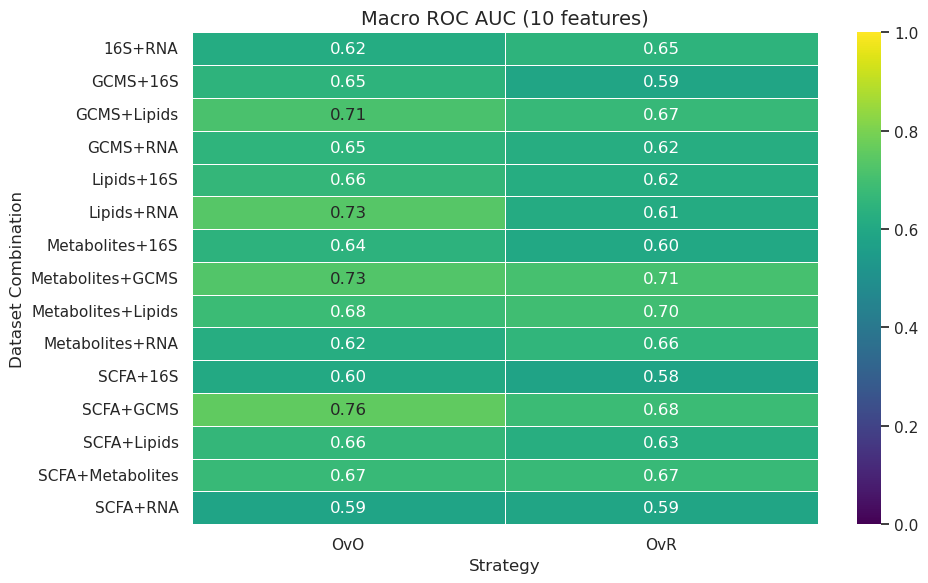

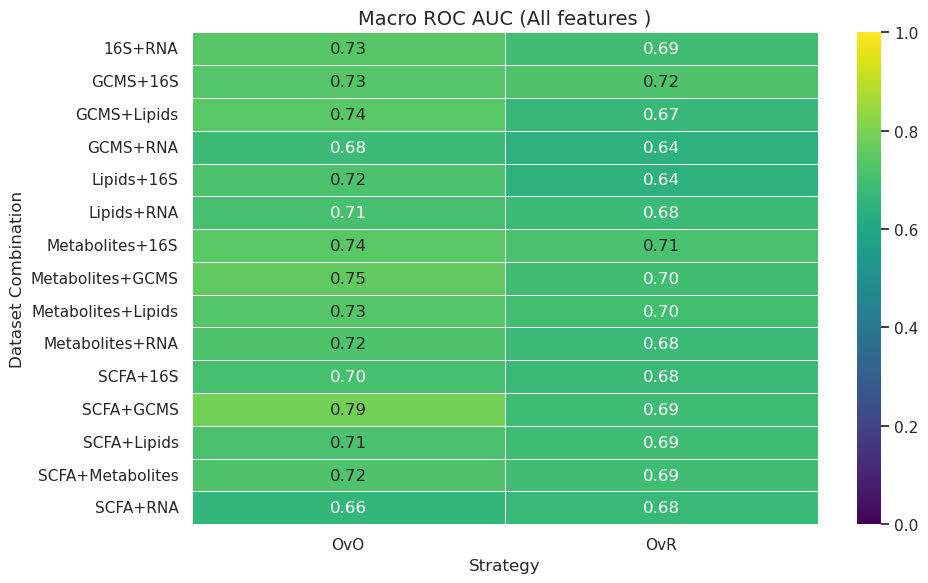

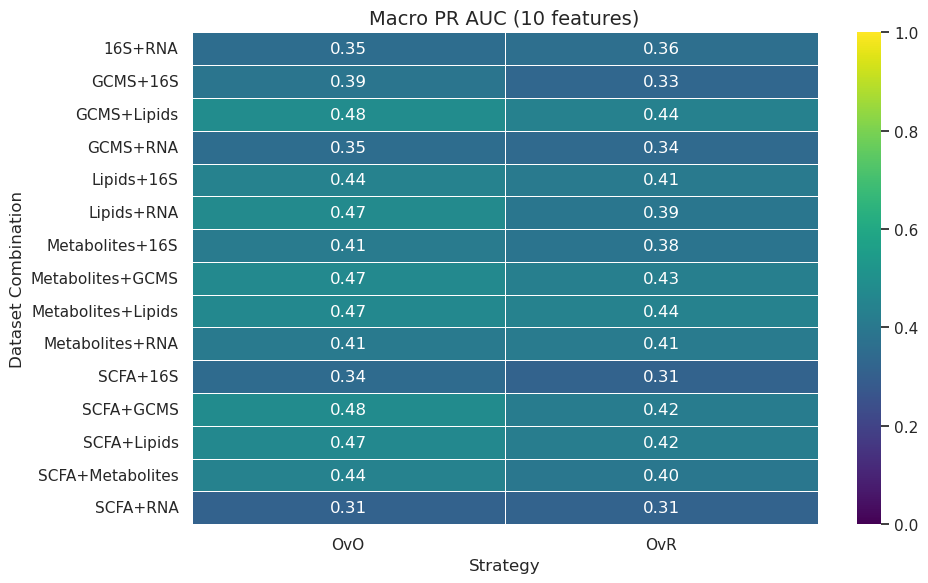

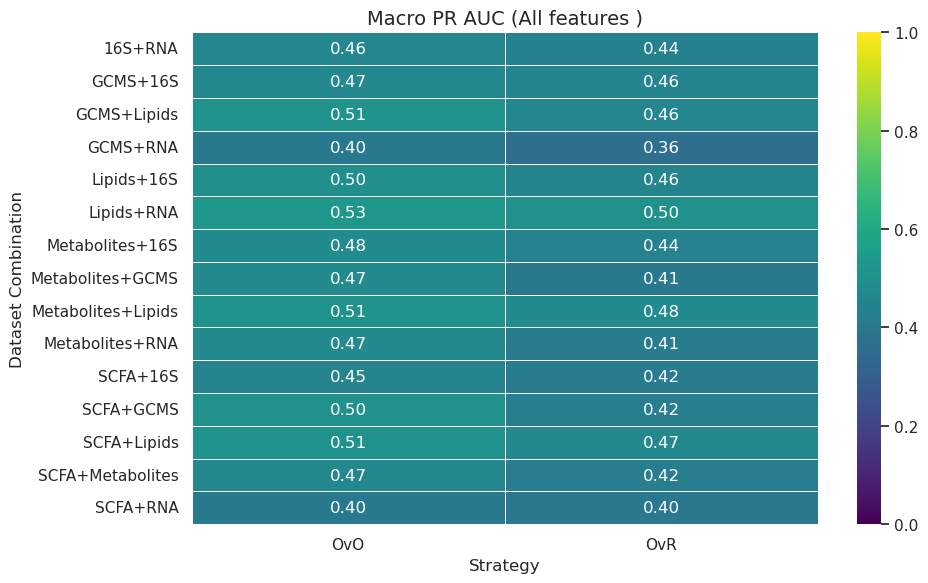

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

df = pd.read_csv(
    "HP_analysis_10_2025/benchmark/results/combinations_of_2_datasets(no_grid).csv"
)

# Macro only
df_macro = df[df["Class"] == "Macro"]

def plot_macro_heatmap(metric, num_features=None, all_except_10=False):
    if all_except_10:
        df_plot = df_macro[df_macro["Features (k)"] != 10]
        title_suffix = "All features "
    else:
        df_plot = df_macro[df_macro["Features (k)"] == 10]
        title_suffix = f"{num_features} features"

    pivot = df_plot.pivot_table(
        index="Label",
        columns="Type",
        values=metric,
        aggfunc="mean"
    )

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        vmin=0,
        vmax=1,
        linewidths=0.5
    )

    plt.title(f"Macro {metric} ({title_suffix})", fontsize=14)
    plt.xlabel("Strategy")
    plt.ylabel("Dataset Combination")
    plt.tight_layout()
    plt.show()


# Plot
for metric in ["ROC AUC", "PR AUC"]:
    plot_macro_heatmap(metric, num_features=10)
    plot_macro_heatmap(metric, all_except_10=True)


# ROC AUC and PR AUC for dataset combinations using RF model for 10 and all features

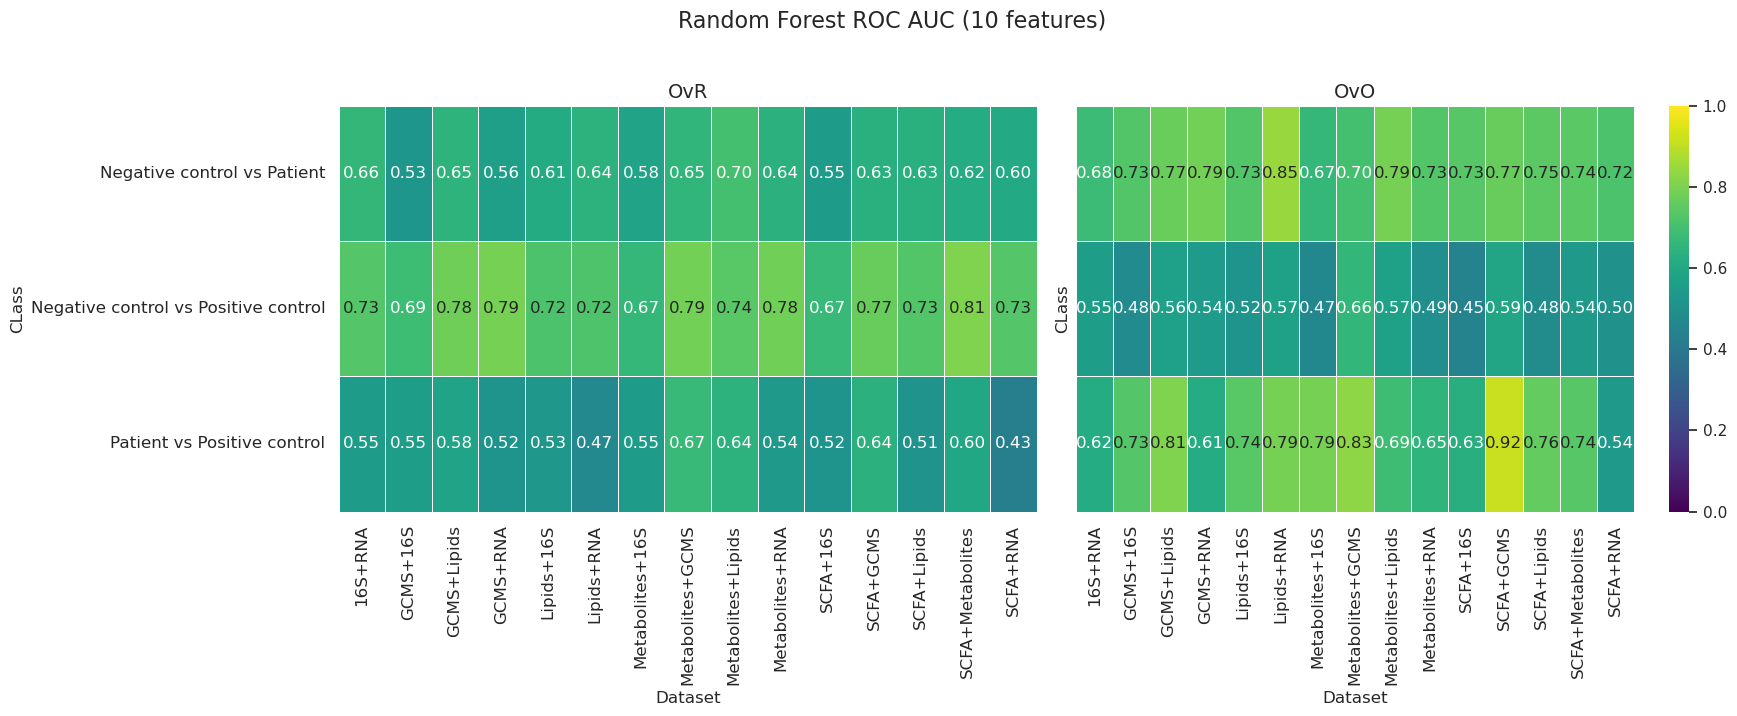

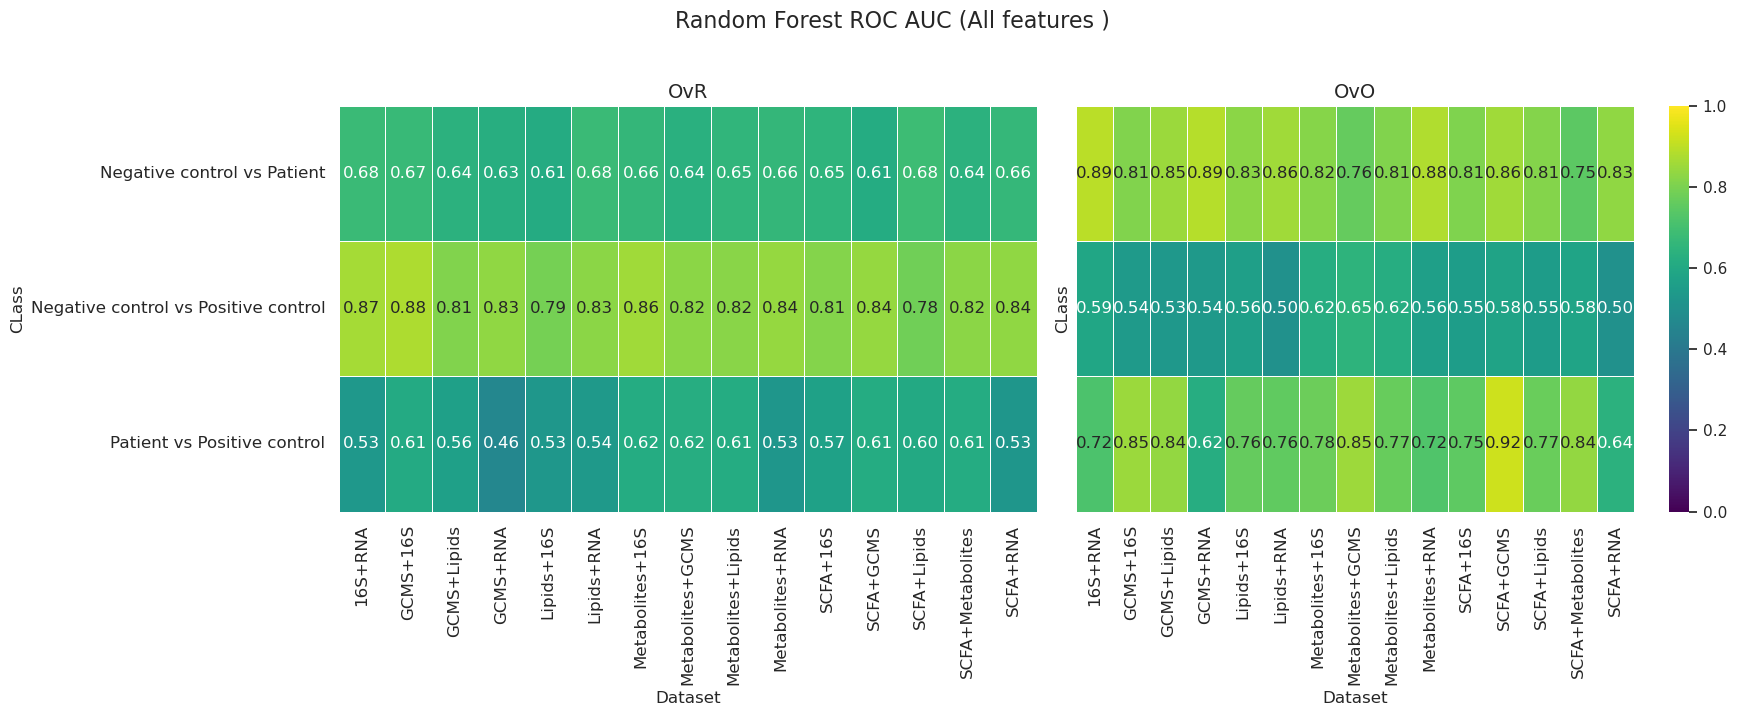

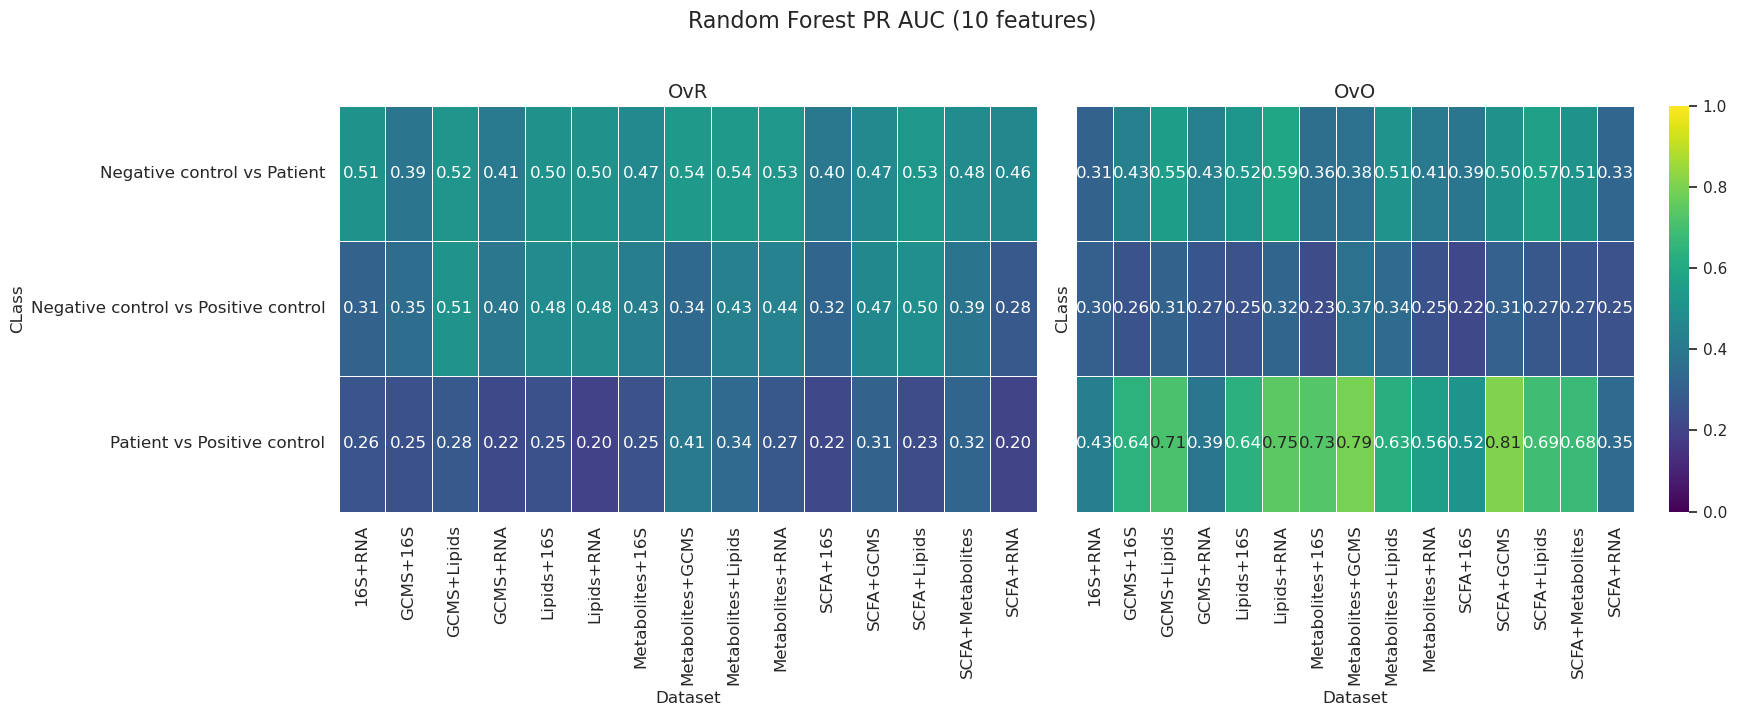

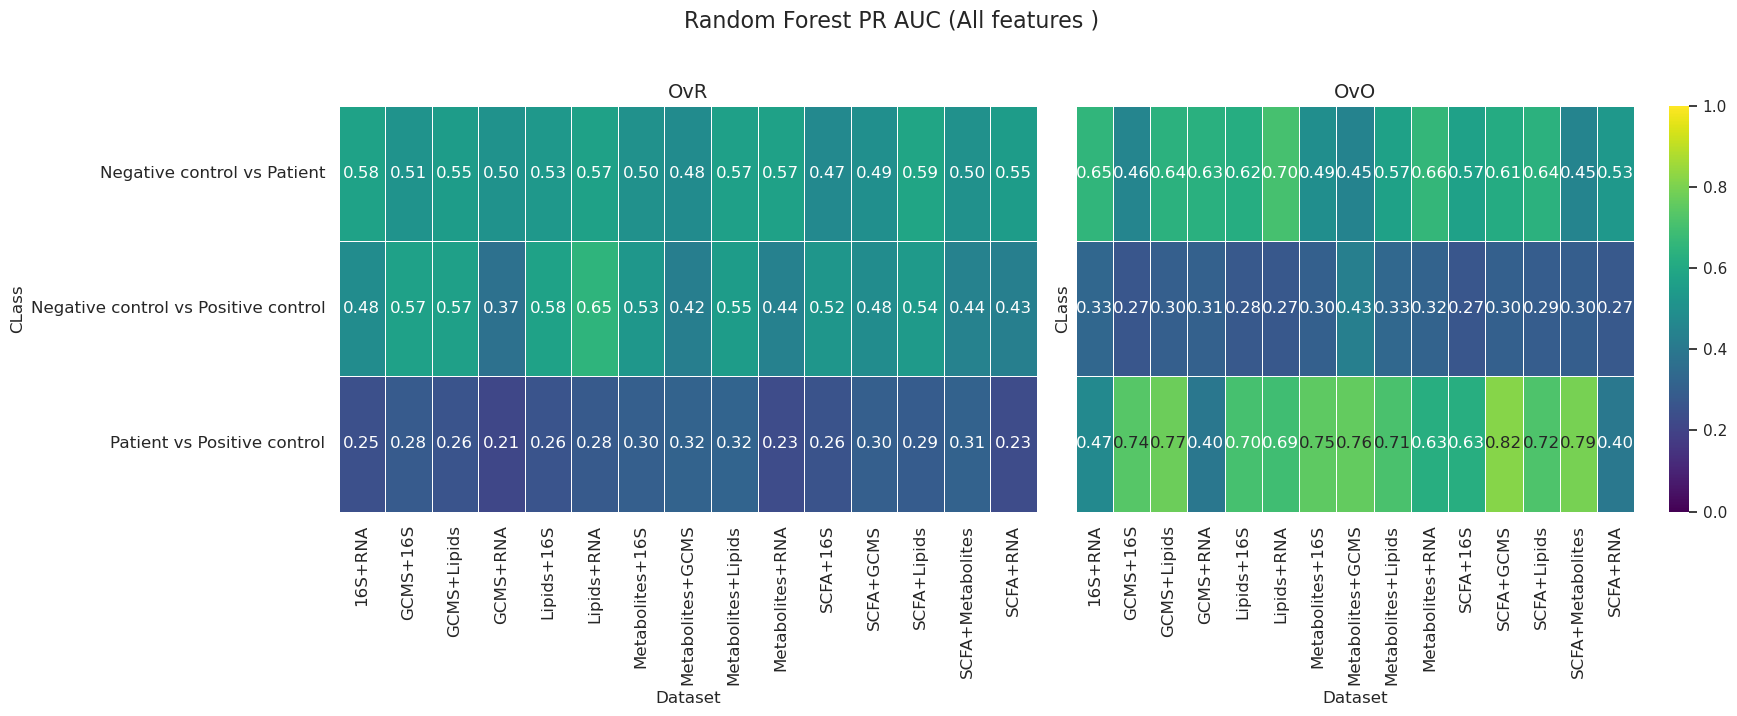

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Load RF results
df = pd.read_csv(
    "HP_analysis_10_2025/benchmark/results/combinations_of_2_datasets(no_grid).csv"
)

# Keep ONLY non-Macro classes
df_non_macro = df[df["Class"] != "Macro"]

def plot_metric_by_class_heatmap(metric, title, num_features=None, all_except_10=False):
    if all_except_10:
        df_plot = df_non_macro[df_non_macro["Features (k)"] != 10]
        feature_label = "All features "
    else:
        df_plot = df_non_macro[df_non_macro["Features (k)"] == 10]
        feature_label = f"{num_features} features"

    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

    for ax, t in zip(axes, ["OvR", "OvO"]):
        df_t = df_plot[df_plot["Type"] == t]

        pivot = df_t.pivot_table(
            index="Class",
            columns="Label",
            values=metric,
            aggfunc="mean"
        )

        sns.heatmap(
            pivot,
            ax=ax,
            annot=True,
            fmt=".2f",
            cmap="viridis",
            vmin=0,
            vmax=1,
            linewidths=0.5,
            cbar=ax == axes[-1]  # show colorbar only once
        )

        ax.set_title(f"{t}", fontsize=14)
        ax.set_xlabel("Dataset")
        ax.set_ylabel("CLass")
        ax.tick_params(axis="x", rotation=90, labelsize=12)
        ax.tick_params(axis="y", rotation=0, labelsize=12)

    fig.suptitle(
        f"{title} ({feature_label})",
        fontsize=16,
        y=1.02
    )

    plt.tight_layout()
    plt.show()


# Metrics to plot
metrics = ["ROC AUC", "PR AUC"]

for metric in metrics:
    plot_metric_by_class_heatmap(
        metric,
        f"Random Forest {metric}",
        num_features=10
    )
    plot_metric_by_class_heatmap(
        metric,
        f"Random Forest {metric}",
        all_except_10=True
    )


# Hyperparameter Tuning for Random Forest using Grid Search on combined datset

In [11]:
n_seeds = 2
ks = [10,100,len(df_combined.columns)]
result_path="HP_analysis_10_2025/benchmark/results/Hyperparameter_tuning_rf(grid_search).csv"

# Check if the file exists and remove it once
if os.path.exists(result_path):
    print(f"File {result_path} exists. Deleting it to start fresh.")
    os.remove(result_path)
    

run_classification(df_combined, y_target, ks, n_seeds,result_path,"combined", "rf", None,use_grid=True)

    

File HP_analysis_10_2025/benchmark/results/Hyperparameter_tuning_rf(grid_search).csv exists. Deleting it to start fresh.
features(ks):  [10, 100, 68267]
seeds:  2
CV for seed 0 and 10 features
Performing One vs Rest classification
Macro ROC AUC (OvR): 0.6679
Macro Precision (OvR): 0.4194
Macro Recall (OvR): 0.3852
Macro F1 (OvR): 0.3116
Macro MCC (OvR): 0.0739
Macro PR AUC (OvR): 0.4445
Performing One vs One classification
Macro ROC AUC (OvO): 0.6411
Macro Precision (OvO): 0.4810
Macro Recall (OvO): 0.1889
Macro F1 (OvO): 0.2695
Macro MCC (OvO): 0.1656
Macro PR AUC (OvO): 0.4375
{'Negative control vs Rest - Precision': 0.30578512396694213, 'Negative control vs Rest - Recall': 0.8222222222222222, 'Negative control vs Rest - F1': 0.4457831325301205, 'Negative control vs Rest - MCC': np.float64(-0.1940275231260727), 'Negative control vs Rest - PR AUC': np.float64(0.5071216411139143), 'Negative control vs Rest - ROC AUC': np.float64(0.5724094881398252), 'Patient vs Rest - Precision': 0.666

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.7178
Macro Precision (OvO): 0.6667
Macro Recall (OvO): 0.1778
Macro F1 (OvO): 0.2807
Macro MCC (OvO): 0.3096
Macro PR AUC (OvO): 0.5481
{'Negative control vs Rest - Precision': 0.30952380952380953, 'Negative control vs Rest - Recall': 0.8666666666666667, 'Negative control vs Rest - F1': 0.45614035087719296, 'Negative control vs Rest - MCC': np.float64(-0.2209792238450104), 'Negative control vs Rest - PR AUC': np.float64(0.531988314556065), 'Negative control vs Rest - ROC AUC': np.float64(0.6309612983770287), 'Patient vs Rest - Precision': 0.8, 'Patient vs Rest - Recall': 0.26666666666666666, 'Patient vs Rest - F1': 0.4, 'Patient vs Rest - MCC': np.float64(0.42963727941822466), 'Patient vs Rest - PR AUC': np.float64(0.6182692256609106), 'Patient vs Rest - ROC AUC': np.float64(0.8145658263305322), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest - MCC': np.float64(

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.7469
Macro Precision (OvO): 0.6667
Macro Recall (OvO): 0.1778
Macro F1 (OvO): 0.2778
Macro MCC (OvO): 0.3066
Macro PR AUC (OvO): 0.5487
{'Negative control vs Rest - Precision': 0.3230769230769231, 'Negative control vs Rest - Recall': 0.9333333333333333, 'Negative control vs Rest - F1': 0.48, 'Negative control vs Rest - MCC': np.float64(-0.15383318873632176), 'Negative control vs Rest - PR AUC': np.float64(0.5473035180740491), 'Negative control vs Rest - ROC AUC': np.float64(0.648689138576779), 'Patient vs Rest - Precision': 1.0, 'Patient vs Rest - Recall': 0.2, 'Patient vs Rest - F1': 0.3333333333333333, 'Patient vs Rest - MCC': np.float64(0.4262386530020208), 'Patient vs Rest - PR AUC': np.float64(0.6961114136376352), 'Patient vs Rest - ROC AUC': np.float64(0.8593837535014006), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest - MCC': np.float64(-0.04657127599530

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.6700
Macro Precision (OvO): 0.6111
Macro Recall (OvO): 0.1333
Macro F1 (OvO): 0.2004
Macro MCC (OvO): 0.2187
Macro PR AUC (OvO): 0.4798
{'Negative control vs Rest - Precision': 0.3153846153846154, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.4685714285714286, 'Negative control vs Rest - MCC': np.float64(-0.24668745581139884), 'Negative control vs Rest - PR AUC': np.float64(0.6086322388040013), 'Negative control vs Rest - ROC AUC': np.float64(0.6697877652933831), 'Patient vs Rest - Precision': 0.5, 'Patient vs Rest - Recall': 0.06666666666666667, 'Patient vs Rest - F1': 0.11764705882352941, 'Patient vs Rest - MCC': np.float64(0.15149987190590394), 'Patient vs Rest - PR AUC': np.float64(0.5363777778101231), 'Patient vs Rest - ROC AUC': np.float64(0.8436974789915965), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest - M

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro ROC AUC (OvO): 0.7400
Macro Precision (OvO): 0.6111
Macro Recall (OvO): 0.1333
Macro F1 (OvO): 0.2004
Macro MCC (OvO): 0.2187
Macro PR AUC (OvO): 0.4988
{'Negative control vs Rest - Precision': 0.32575757575757575, 'Negative control vs Rest - Recall': 0.9555555555555556, 'Negative control vs Rest - F1': 0.4858757062146893, 'Negative control vs Rest - MCC': np.float64(-0.17310785645466809), 'Negative control vs Rest - PR AUC': np.float64(0.5636696839122872), 'Negative control vs Rest - ROC AUC': np.float64(0.6634207240948814), 'Patient vs Rest - Precision': 1.0, 'Patient vs Rest - Recall': 0.06666666666666667, 'Patient vs Rest - F1': 0.125, 'Patient vs Rest - MCC': np.float64(0.24423169902168218), 'Patient vs Rest - PR AUC': np.float64(0.6032572505880492), 'Patient vs Rest - ROC AUC': np.float64(0.8224089635854342), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest - MCC': np.float

# Plotting RF model performance(macro scores) with or without grid search for 10,100 and all features on combined dataset

/tmp/ipykernel_14274/2481766997.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grid_macro["Method"] = "GridSearch"
/tmp/ipykernel_14274/2481766997.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_grid_macro["Method"] = "NoGridSearch"


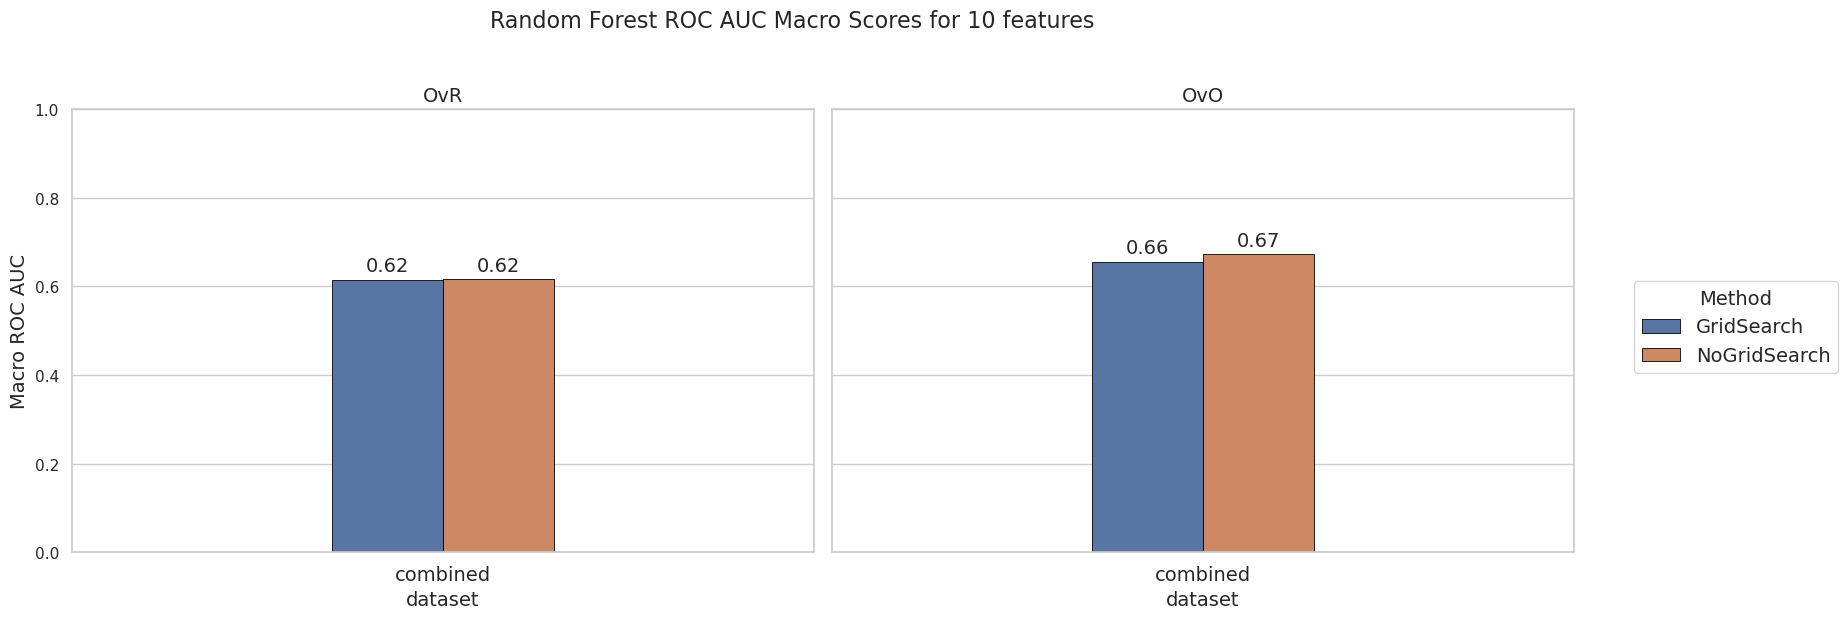

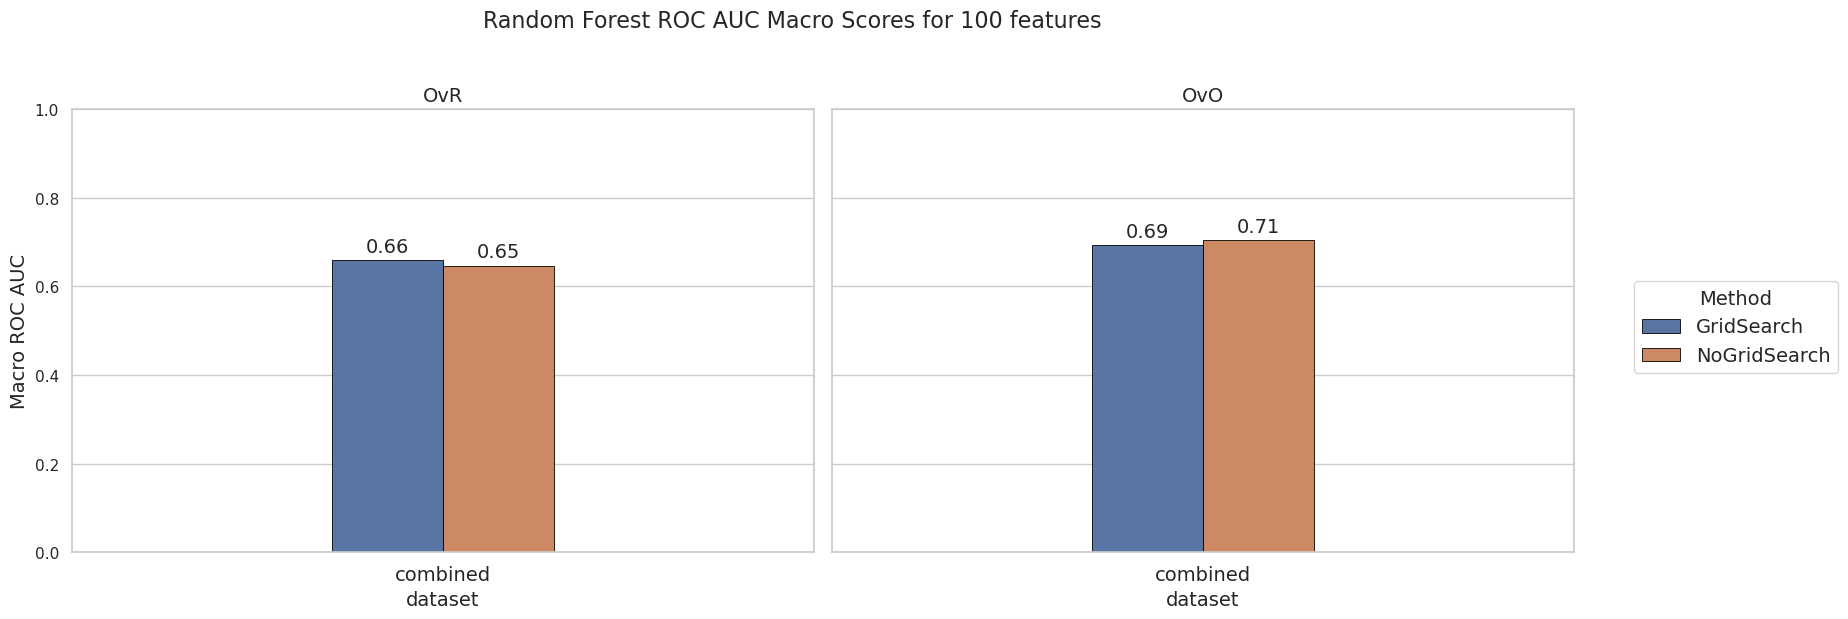

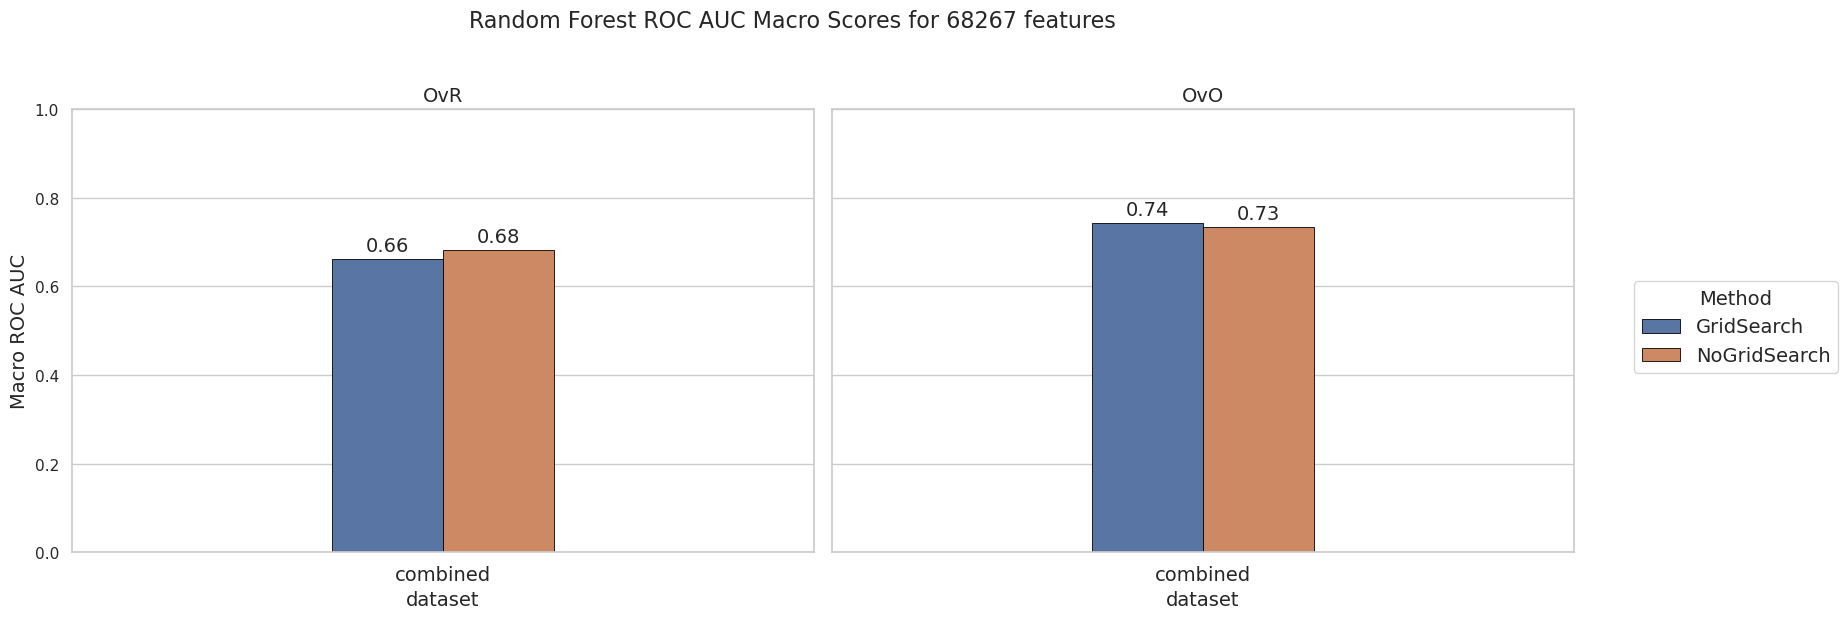

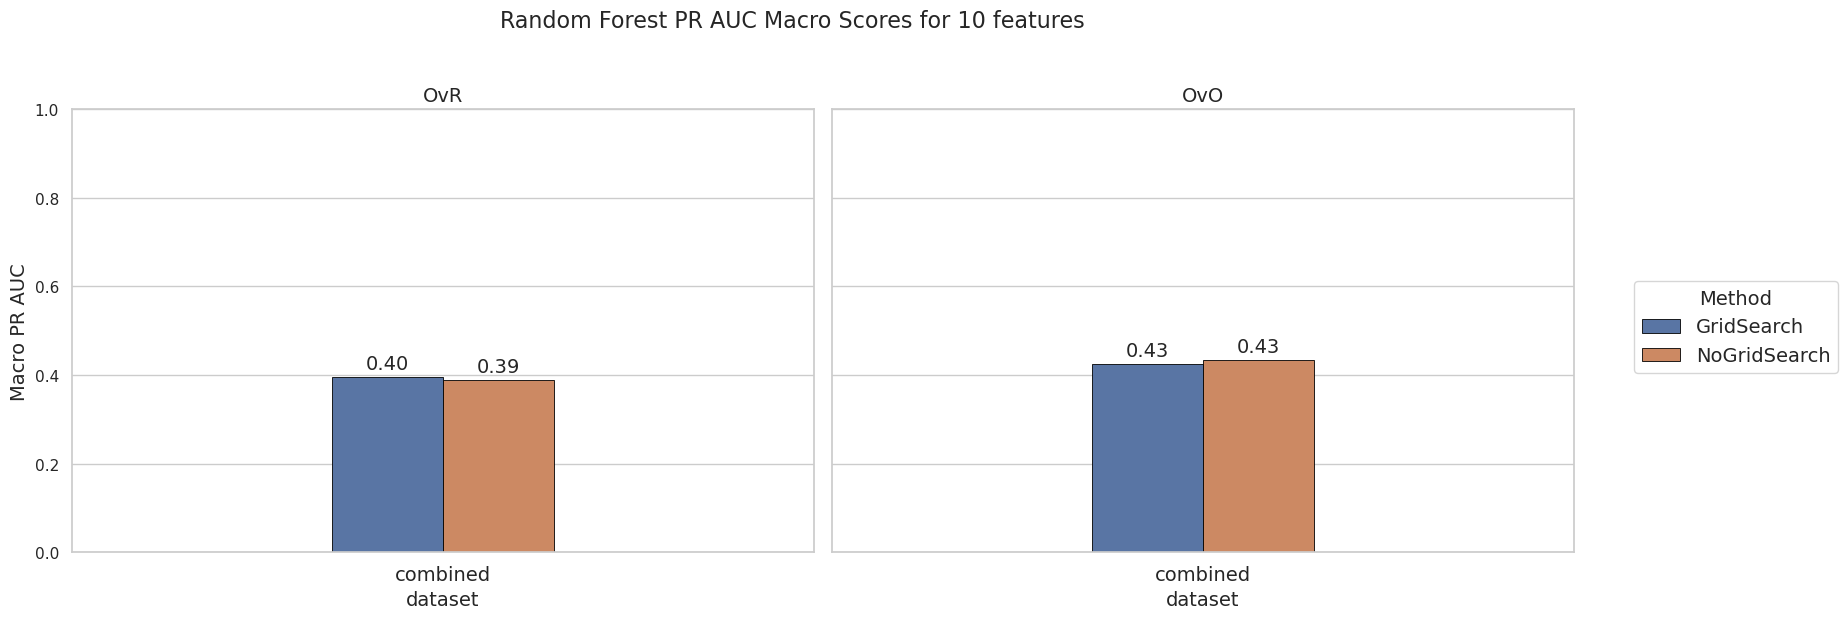

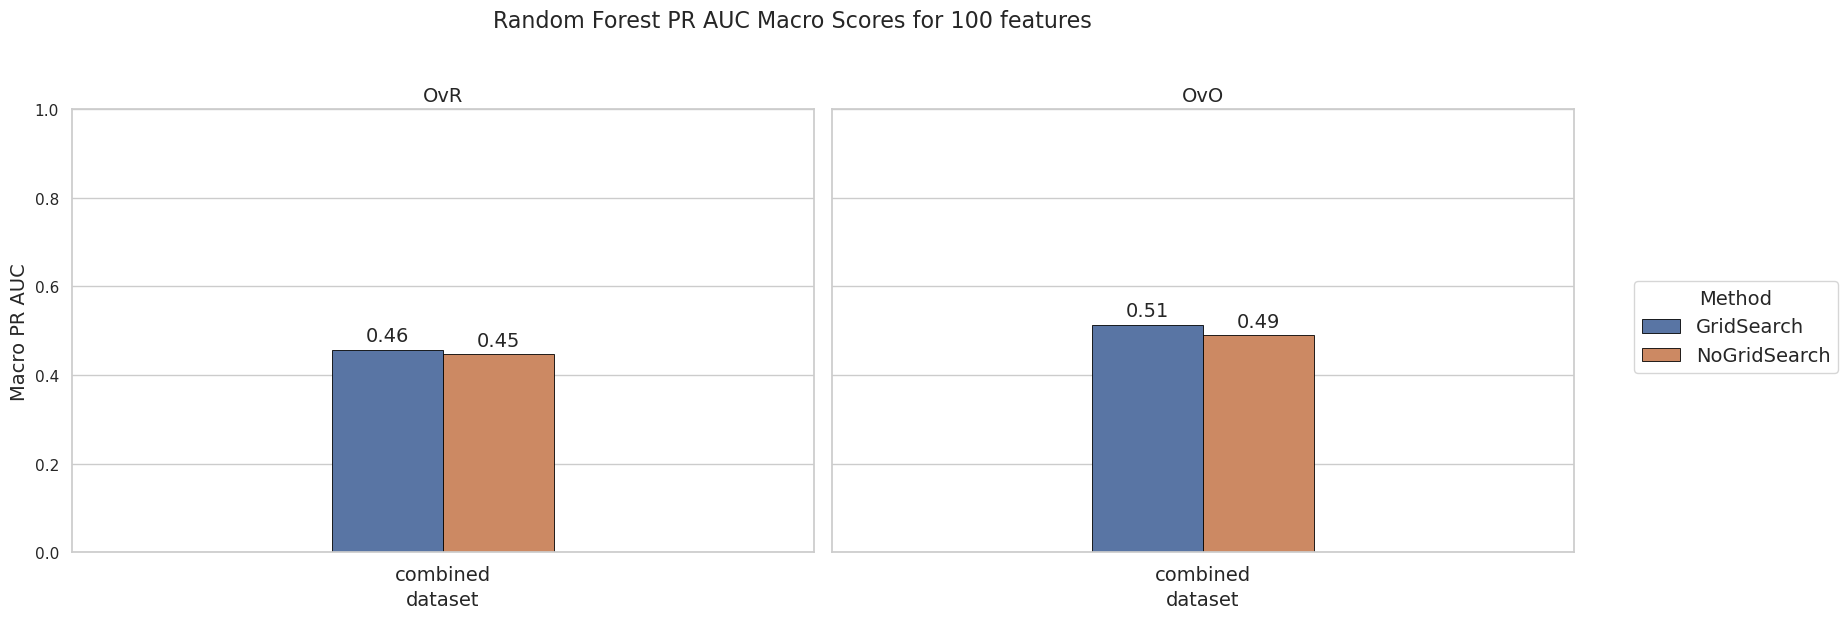

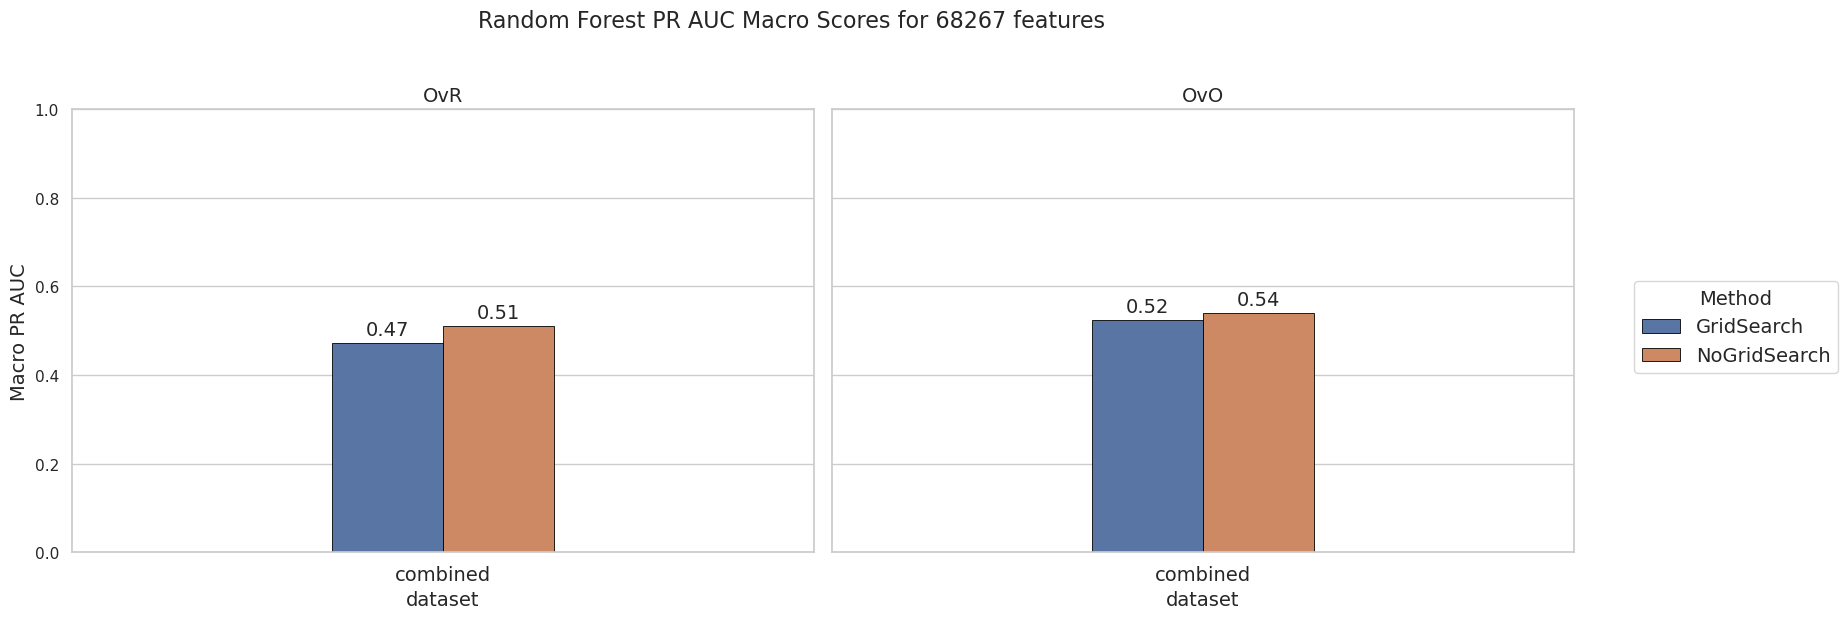

In [124]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Feature sets to plot
feature_sets = [10, 100, len(df_combined.columns)]

# Load data
df_grid = pd.read_csv("HP_analysis_10_2025/benchmark/results/Hyperparameter_tuning_rf(grid_search).csv")
df_no_grid = pd.read_csv("HP_analysis_10_2025/benchmark/results/diff_models_on_combined(no grid).csv")

# Keep only Macro scores
df_grid_macro = df_grid[df_grid["Class"] == "Macro"]
df_no_grid_macro = df_no_grid[
    (df_no_grid["Class"] == "Macro") & (df_no_grid["Model"] == "rf")
]

# Add column to distinguish method
df_grid_macro["Method"] = "GridSearch"
df_no_grid_macro["Method"] = "NoGridSearch"

# Combine datasets
df_comb = pd.concat([df_grid_macro, df_no_grid_macro], ignore_index=True)

# Metrics to plot
metrics = ["ROC AUC", "PR AUC"]

for metric in metrics:
    for f in feature_sets:
        df_feat = df_comb[df_comb["Features (k)"] == f]

        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

        for ax, t in zip(axes, ["OvR", "OvO"]):
            df_type = df_feat[df_feat["Type"] == t]

            sns.barplot(
                data=df_type,
                x="Label",      
                y=metric,
                hue="Method",   # GridSearch vs NoGrid
                ci=None,
                edgecolor="black",
                linewidth=0.6,
                width=0.3,
                ax=ax
            )

            ax.set_title(f"{t}", fontsize=14)
            ax.set_xlabel("dataset", fontsize=14)
            ax.set_ylabel(f"Macro {metric}", fontsize=14)
            ax.set_ylim(0, 1)
            ax.tick_params(axis="x", rotation=0, labelsize=14)

            # Annotate bars
            for container in ax.containers:
                ax.bar_label(container, fmt="%.2f", padding=3, fontsize=14)

        # Legend outside
        handles, labels = axes[1].get_legend_handles_labels()
        fig.legend(
            handles, labels,
            title="Method",
            title_fontsize=14,
            prop={'size': 14},
            bbox_to_anchor=(1.02, 0.5),
            loc="center left"
        )
        axes[0].get_legend().remove()
        axes[1].get_legend().remove()

        fig.suptitle(f"Random Forest {metric} Macro Scores for {f} features", fontsize=16, y=1.03)
        plt.tight_layout()
        plt.show()


# Plotting RF model performance(ROC and PR AUC scores) with or without grid search for 10,100 and all features on combined dataset

/tmp/ipykernel_14274/3172715690.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grid_non_macro["Method"] = "GridSearch"
/tmp/ipykernel_14274/3172715690.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_grid_non_macro["Method"] = "NoGridSearch"


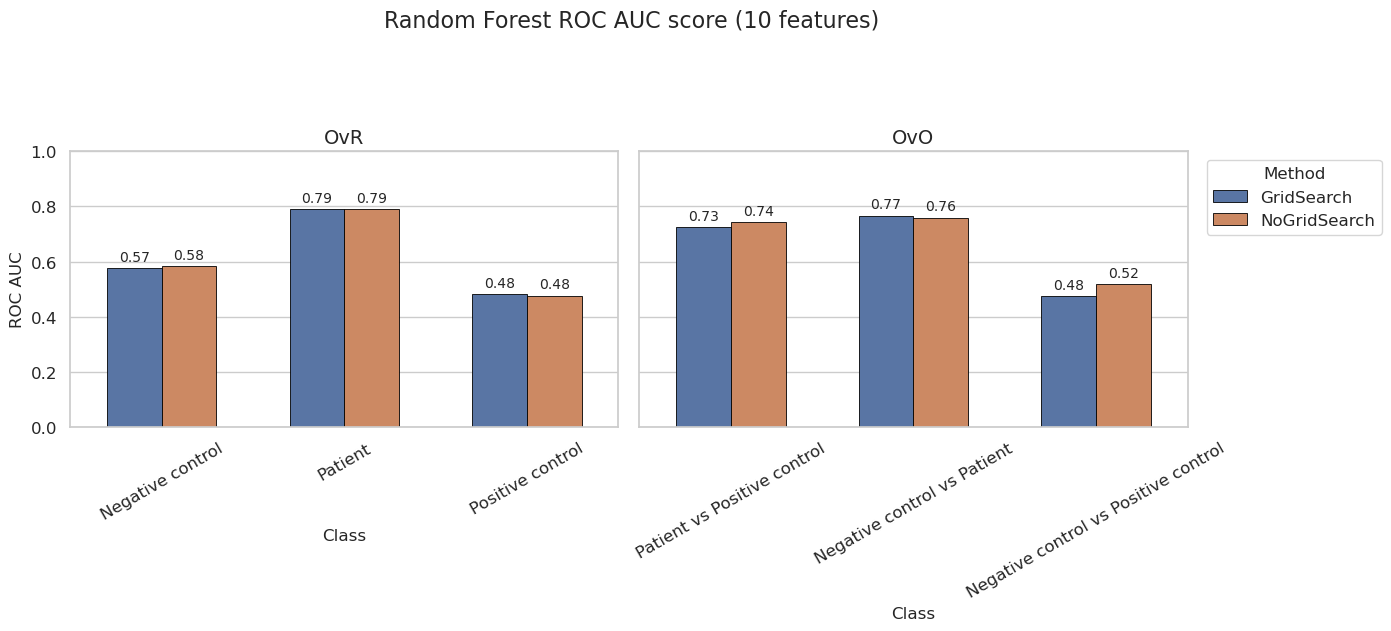

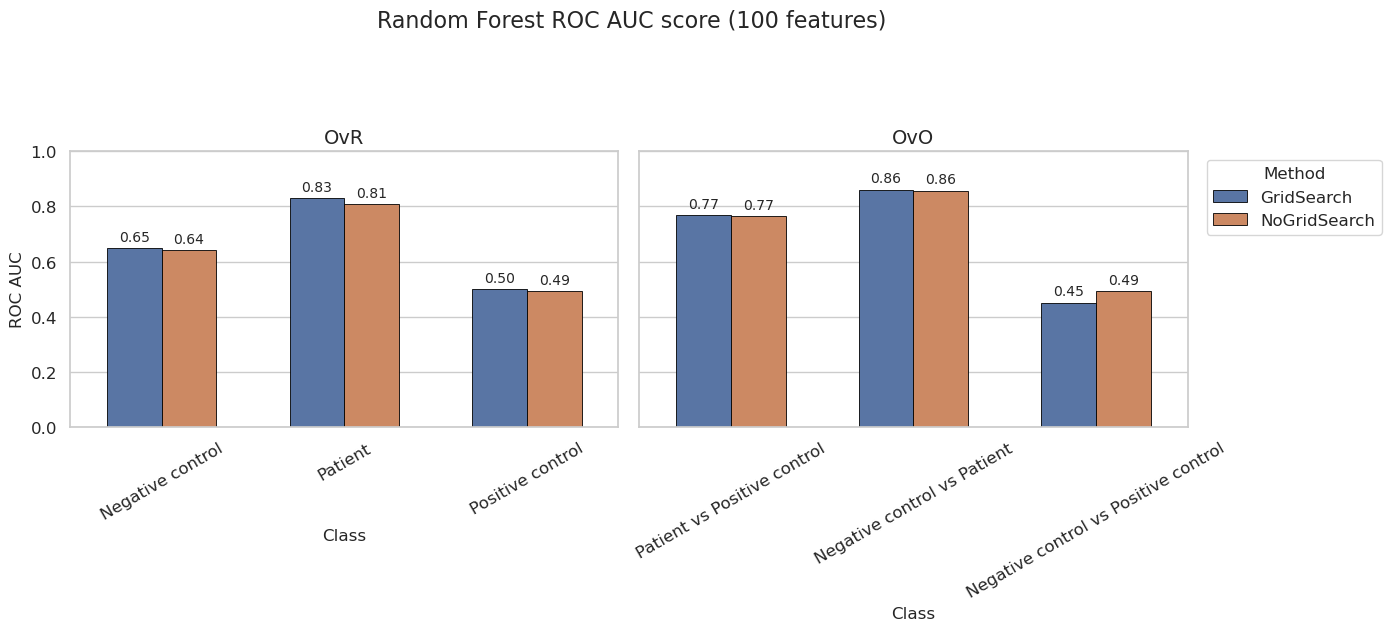

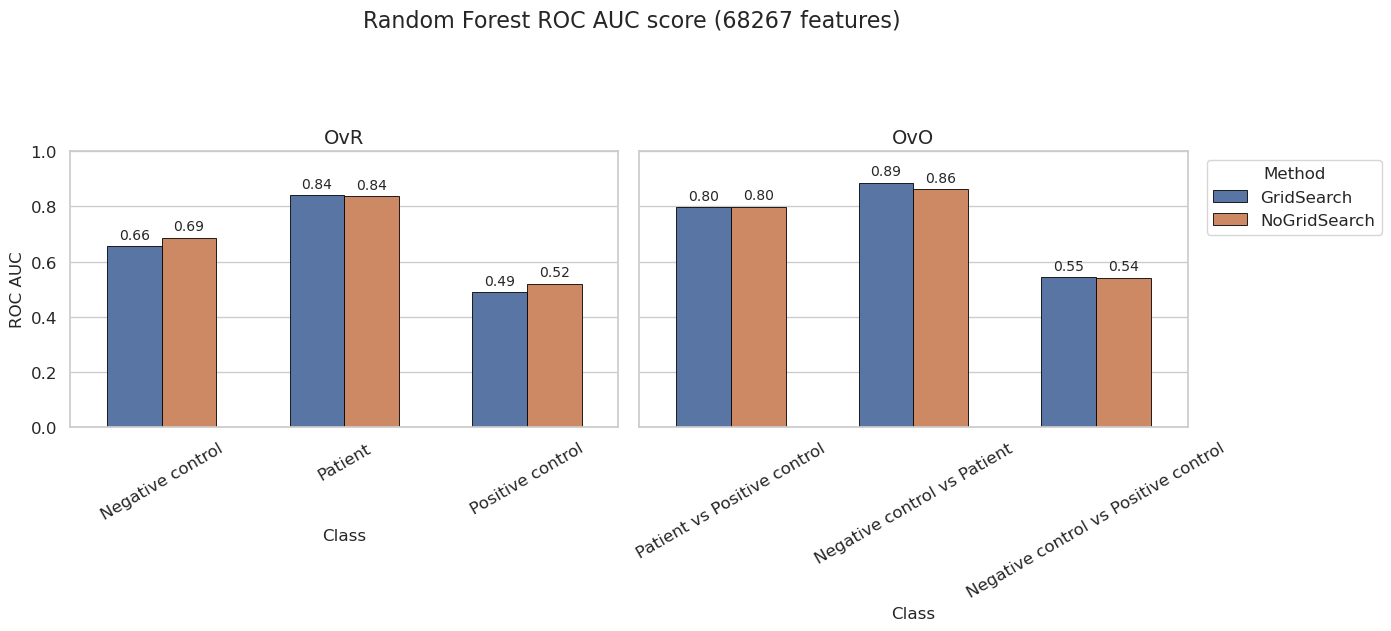

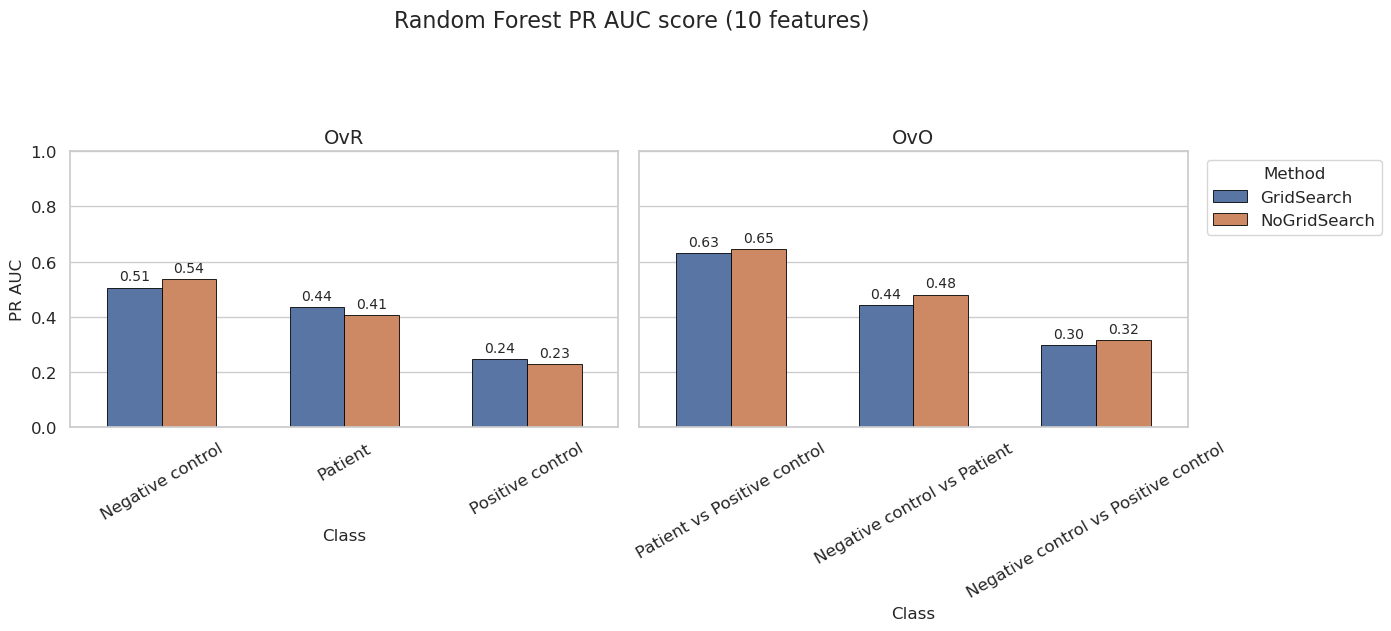

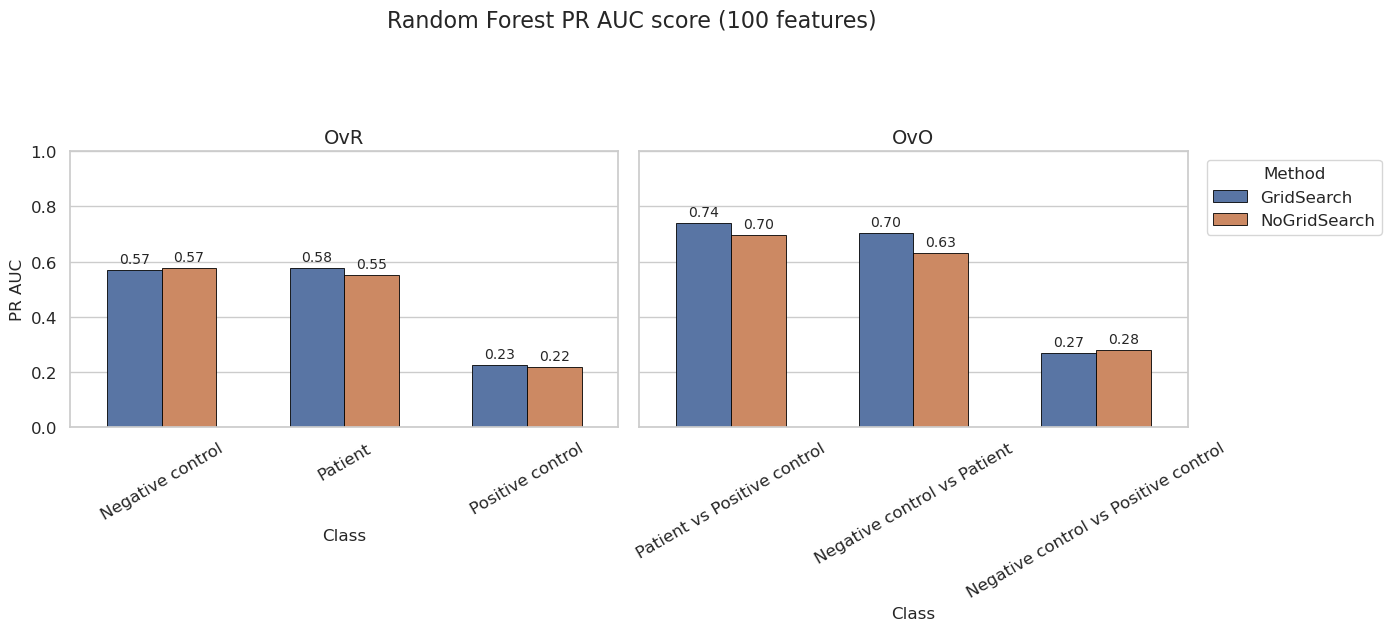

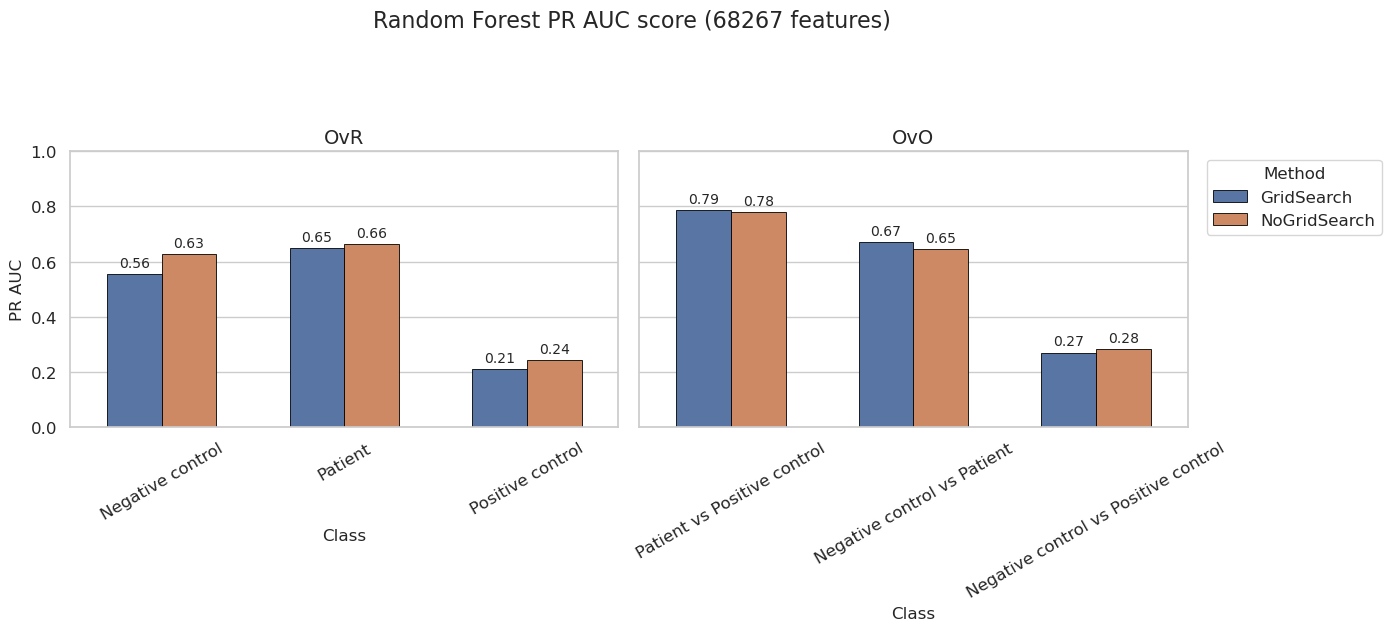

In [135]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

feature_sets = [10, 100, len(df_combined.columns)]

# Load data
df_grid = pd.read_csv("HP_analysis_10_2025/benchmark/results/Hyperparameter_tuning_rf(grid_search).csv")
df_no_grid = pd.read_csv("HP_analysis_10_2025/benchmark/results/diff_models_on_combined(no grid).csv")

# Keep only non-Macro classes
df_grid_non_macro = df_grid[df_grid["Class"] != "Macro"]
df_no_grid_non_macro = df_no_grid[(df_no_grid["Class"] != "Macro") & (df_no_grid["Model"] == "rf")]

# Add Method column
df_grid_non_macro["Method"] = "GridSearch"
df_no_grid_non_macro["Method"] = "NoGridSearch"

# Combine datasets
df_comb = pd.concat([df_grid_non_macro, df_no_grid_non_macro], ignore_index=True)

# Metrics to plot
metrics = ["ROC AUC", "PR AUC"]


def plot_non_macro_metric(metric, feature_set):
    """
    Plot per-class metric (non-Macro) for a specific feature set, with OvR/OvO subplots.
    Bars: GridSearch vs NoGrid
    """
    df_feat = df_comb[df_comb["Features (k)"] == feature_set]
    feature_label = f"{feature_set} features"

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    for ax, t in zip(axes, ["OvR", "OvO"]):
        df_type = df_feat[df_feat["Type"] == t]

        sns.barplot(
            data=df_type,
            x="Class",
            y=metric,
            hue="Method",
            ci=None,
            edgecolor="black",
            linewidth=0.6,
            width=0.6,
            ax=ax
        )

        ax.set_title(f"{t}", fontsize=14)
        ax.set_xlabel("Class", fontsize=12)
        ax.set_ylabel(f"{metric}", fontsize=12)
        ax.set_ylim(0, 1)
        ax.tick_params(axis="x", rotation=30, labelsize=12)
        ax.tick_params(axis="y", labelsize=12)

        # Annotate bar values
        for container in ax.containers:
            ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)

    # Legend outside
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(
        handles, labels,
        title="Method",
        title_fontsize=12,
        prop={'size': 12},
        bbox_to_anchor=(1.02, 1),
        loc="upper left"
    )
    axes[0].get_legend().remove()

    # Title with feature info
    fig.suptitle(f"Random Forest {metric} score ({feature_label})", fontsize=16, y=1.05, x=0.40)
    plt.tight_layout(rect=[0, 0, 0.88, 0.95])
    plt.show()


# Loop through metrics and hard-coded feature sets
for metric in metrics:
    for f in feature_sets:
        plot_non_macro_metric(metric, f)
